# IRRmodel\*WCM calibration with PSO on KGE of $\sigma^0$

The v9 code (OR def) is a final, cleaned and commented version.
This version, wrt to v8, implements an hourly ET0 calculated with hourly FAO-56 Penman-Monteith and a SWB model that is properly corrected for hourly calculation of the evapotranspiration.
Kc curves are also externally defined in a module of their own.

# Dependencies

In [1]:
import sys
sys.path.append('../')

from modules.funcs import *
from modules.funcs_pso import *
from modules.funcs_plot import *
from modules.funcs_analysis import *
from modules.IRRI_WCM_model import *
from modules.Kc_curve import Kc_curve
from modules.EPOT_Hargreaves_pyeto import *

from scipy.signal import savgol_filter

# Data pre-processing

Input data formatting convention:
- ausiliary variables for extraction of data (directory name, file name, etc...)
- extraction into pd dataframe
- cleaning, resampling: drop unnecessary columns, set index to daily DateIndex

In [2]:
print('Starting...\n'
      +'#-------------------------------------------------------------\n'
      #+'Use of satellite-derived SM is provided for comparison, not calibration.\n'
     )
verbose = True if input("Verbose data extraction? (Describe datasets/files) [y/n]")=='y' else False

params = []; norma = ''

print('\n#-------------SWB model parameters-------------')
irri = False
year = int(input('Do you want to calibrate on year 2017 or 2020? [2017/2020]'))
freq = 'h' # input('Daily or hourly frequency? [d/h]')

print('\n#-------------WCM model parameters-------------')
units = 'lin' # input('Calibrate WCM in linear or dB scale (determines scale of A)? [lin/db]')
opt_veg = 'NDVI'

print('\n#------------Optimization parameters-----------')
opt_calib = '1' # input('Cost function (KGE) on sigma0 (1) or sigma0 and soil moisture (2)? [1/2]')
opt_cost = 'KGE'

PAR_str_add = '_' + str(year) + input('Any addition to parameters\' names? [Type string to add]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/[l2]] ')=='l1' else 2
verbose_calib = True if input('Verbose during calibration? [y/n]')=='y' else False
automate = True if input('Run and save everything automatically? [y/n]')=='y' else False

# check if params are already present
opt_params = input('Params already present: overwrite [y] or append [n]? [y/n]') if len(params)>0 else ''
if opt_params=='y': params = []

Starting...
#-------------------------------------------------------------


#-------------SWB model parameters-------------

#-------------WCM model parameters-------------

#------------Optimization parameters-----------


## IRRmodel

Frequency: daily

Inputs:
- rain (sum, end of day)
- et0 (daily)

Comparisons:
- irrigation (sum, end of day)
- soil moisture (mean, end of day)

In [5]:
#----------------------------------------------------------------------------
# Budrio field data from platinum_df tables

# Freq: H
# Data extracted:
# - SWC (as input SWB/comparison)
# - rain (as input SWB)
# - irrigation (as input SWB)
# - temperature (as input SWB, ET0 estimate)

platinum_df = pd.ExcelFile('../Inputs/Platinum_Budrio.xlsx', engine='openpyxl')
if year==2017: sheet='2017_1h'
if year==2020: sheet='2020_1h'
platinum_df = platinum_df.parse(sheet)
# platinum_df = pd.concat([platinum_df.parse('2017_1h'), platinum_df.parse('2020_1h')])

# Column 'Date' contains date+hour = hourly information
# Column 'Data' contains only date = daily information
platinum_df['Ora_1'] = pd.to_datetime(platinum_df['Ora'].astype('str')).apply(lambda x: x.time())
platinum_df['Data_1'] = pd.to_datetime(platinum_df['Data'].astype('str')).apply(lambda x: x.date())
platinum_df['Datetime'] = platinum_df.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum_df = platinum_df.drop(['ID', 'Data', 'Ora', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
platinum_df = platinum_df.set_index('Datetime')
platinum_resampled = platinum_df.resample('D', origin='end_day')
if verbose: platinum_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5125 entries, 2017-04-03 11:00:00 to 2017-11-02 23:00:00
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SWC[m3/m3]       4884 non-null   float64
 1   Pioggia[mm]      5045 non-null   float64
 2   Irrigazione[mm]  5125 non-null   float64
 3   Temperatura[°C]  5094 non-null   float64
dtypes: float64(4)
memory usage: 200.2 KB


In [6]:
#----------------------------------------------------------------------------
# Budrio field data from meteo tables

# Freq: H
# Data extracted:
# none
# Needed for eto from FAO PM 

meteo_df = pd.ExcelFile('../Inputs/Budrio_Meteo.xlsx', engine='openpyxl')
meteo_df = meteo_df.parse(str(year))
# meteo_df = pd.concat([meteo_df.parse('2017'), meteo_df.parse('2020')]).set_index('ID')

# Column 'Date' contains date+hour = hourly information
meteo_df['Datetime'] = meteo_df.apply(lambda r : dtt.datetime.combine(r['Data'],r['Ora']),1)
meteo_df = meteo_df.set_index('Datetime')
meteo_df = meteo_df.drop(['Data', 'Ora'],axis=1)

if verbose: meteo_df.info()
# meteo_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5125 entries, 2017-04-03 11:00:00 to 2017-11-02 23:00:00
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              5125 non-null   int64  
 1   Raffica di vento [m/s]          5125 non-null   float64
 2   Radiazione solare [W/m2]        5125 non-null   float64
 3   Direzione del vento [°]         5125 non-null   float64
 4   Radiazione UV [MED]             5125 non-null   float64
 5   Velocità del vento [m/s]        5125 non-null   float64
 6   Pressione atmosferica [hPa]     5125 non-null   float64
 7   Punto di rugiada [C°]           5125 non-null   float64
 8   Temperatura Aria Netsens [C°]   5125 non-null   float64
 9   Umidità aria Netsens [%]        5125 non-null   float64
 10  Temperatura Aria Supporto [C°]  5125 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 480.5 KB


In [7]:
# Budrio database
# Freq: H
# Merging of Platinum+Meteo

meteo_h = pd.merge(right=platinum_df, left=meteo_df, on='Datetime')
if verbose: meteo_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5125 entries, 2017-04-03 11:00:00 to 2017-11-02 23:00:00
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              5125 non-null   int64  
 1   Raffica di vento [m/s]          5125 non-null   float64
 2   Radiazione solare [W/m2]        5125 non-null   float64
 3   Direzione del vento [°]         5125 non-null   float64
 4   Radiazione UV [MED]             5125 non-null   float64
 5   Velocità del vento [m/s]        5125 non-null   float64
 6   Pressione atmosferica [hPa]     5125 non-null   float64
 7   Punto di rugiada [C°]           5125 non-null   float64
 8   Temperatura Aria Netsens [C°]   5125 non-null   float64
 9   Umidità aria Netsens [%]        5125 non-null   float64
 10  Temperatura Aria Supporto [C°]  5125 non-null   float64
 11  SWC[m3/m3]                      4884 non-null   float64
 12

In [8]:
lat_deg = 44.570842547510622 # latitude of Budrio (deg)
temp_min = platinum_resampled.min()['Temperatura[°C]'].values
temp_max = platinum_resampled.max()['Temperatura[°C]'].values
temp_mean = platinum_resampled.mean()['Temperatura[°C]'].values
dates = platinum_resampled.asfreq().index
eto = timeseries( dates,
                 [ hargre(lat_deg, dates[i] , temp_min[i], temp_max[i], temp_mean[i])
                  for i in range(len(dates)) ] )
eto_df = pd.DataFrame(eto).rename(columns={0:'Date',1:'EPOT'}).set_index('Date')
if verbose: eto_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214 entries, 2017-04-04 to 2017-11-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EPOT    214 non-null    float64
dtypes: float64(1)
memory usage: 3.3 KB


In [9]:
# Computation of hourly eto by hourly FAO Penman-Monteith equation
# FAO-56 pag. 74

t = [x for x in meteo_h.index if x.year==year]

# Inputs
# ------
RH = meteo_h.loc[t]['Umidità aria Netsens [%] '].values if year==2017 else meteo_h.loc[t]['Umidità aria [%] '].values # mean hourly relative humidity [%]
T = meteo_h.loc[t]['Temperatura[°C]'].values # mean hourly air temperature [°C]
sol_rad = meteo_h.loc[t]['Radiazione solare [W/m2]  '].values # measured solar radiation [J m^-2 s^-1]
sol_rad_hour = sol_rad*3600*1e-6 # [MJ m^-2 h^-1]
T_dew = meteo_h.loc[t]['Punto di rugiada [C°] '].values # dew point [°C]
atmos_pres = meteo_h.loc[t]['Pressione atmosferica [hPa]  '].values/10 # atmospheric pressure [kPa]
wind_s = meteo_h.loc[t]['Velocità del vento [m/s]'].values
epot_hourly = [0.]*len(t)

# Params
# ------
for i in range(len(t)):
    
    lat_deg = 44.570842547510622 # latitude of Budrio (deg)
    lat_rad = np.deg2rad(lat_deg)
    long_deg = 11.53267200001359 # longitude of Budrio (deg)
    long_rad = np.deg2rad(long_deg)
    altitude = 11. # elevation [m]
    doy = t[i].dayofyear
    hour = t[i].hour
    mid_hour = hour+0.5
    
    # Extraterrestrial radiation (et_rad)
    Gsc = 0.0820 # MJ m^-2 min^-1
    dr = inv_rel_dist_earth_sun(doy) # inverse relative distance Earth-Sun
    d = sol_dec(doy) # solar declination [rad]
    phi = lat_rad # latitude [rad]
    lz = 360-15 # longitude of centre of local time zone (CET) (deg W of Greenwhich)
    lm = 360-long_deg # longitude of site (deg W of Greenwhich)
    b = 2*np.pi*(doy-81)/364
    Sc = 0.1645*np.sin(2*b)-0.1255*np.cos(b)-0.025*np.sin(b) # seasonal correction for solar time
    w = np.pi/12*((mid_hour+0.006667*(lz-lm)+Sc)-12) # solar time angle at midpoint of the period
    w1 = w-np.pi/24 # solar time angle at beginning [rad]
    w2 = w+np.pi/24 # solar time angle at end [rad]

    
    et_rad = 12*60/np.pi*Gsc*dr*((w2-w1)*np.sin(phi)*np.sin(d)+np.cos(phi)*np.cos(d)*(np.sin(w2)-np.sin(w1)))
    
    ws = np.arccos(-np.tan(lat_rad)*np.tan(d))
    N = 24/np.pi*ws # daylight hours
    Rs = sol_rad_hour[i] # measured solar radiation [MJ m^-2 h^-1]
    Rso = cs_rad(altitude, et_rad) # clear sky radiation [MJ m^-2 h^-1]
                                 
    avp = avp_from_tdew(T_dew[i]) # actual vapour pressure
    ni_rad = net_in_sol_rad(Rs) # net incoming solar radiation # use this formula, albedo is default value
                                 
    boltz_h = 2.043*1e-10 # Boltzmann constant [MJ m^-2 h^-1]
    e_thr = svp_from_t(T[i]) # saturation vapour pressure
    e_a = e_thr*RH[i]/100# average hourly actual vapour pressure
    Rs_ratio = Rs/Rso if Rs/Rso<1 else 1
    no_rad = boltz_h*T[i]**4*(0.34-0.14*np.sqrt(e_a))*(1.35*Rs_ratio-0.35) # net outgoing radiation corrected for hourly period
    R_n = ni_rad - no_rad # net radiation at grass surface
    
    u2 = wind_s[i]
    G = 0.1*R_n if hour in range(6,18,1) else 0.5*R_n # soil heat flux density, ref. eq. 45, 46 FAO56
    Delta = delta_svp(T[i]) #saturation slope
    gamma = psy_const(atmos_pres[i])# psychrometric constant
    
    epot_hourly[i] = (0.408*Delta*(R_n-G)+gamma*37/(T[i]+273)*u2*(e_thr-e_a))/(Delta+gamma*(1+0.34*u2))

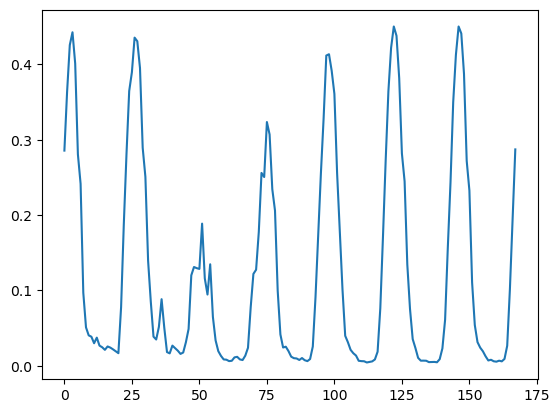

In [10]:
plt.plot(epot_hourly[:24*7])
plt.show()

## WCM

Frequency: multi-daily

Inputs:
- $\sigma^0$, $/theta$ (hourly, rounded to nearest midnight)
- vegetation descriptors (NDVI, LAI, CR) (average, daily)

In [11]:
#----------------------------------------------------------------------------
# Sigma0 values

# Freq: D
# Daily values of backscattering from 2014 to 2022 (complete S1 series)
# Data extracted:
# - sigma0 values, VV and VH
# - angle of incidence of reference orbit (nearest to 40°)

sigma_df = pd.read_csv('../Data//budrio-half.csv', delimiter='\t');
sigma_df['Datetime'] = sigma_df.Date.apply(lambda x : pd.to_datetime(x))
angle_mean_95 = sigma_df.loc[sigma_df.Orb==95]['Angle[°]'].mean()
sigma_df['Angle[°]'] = sigma_df['Angle[°]'].apply(lambda x : angle_mean_95)
sigma_df.Date = sigma_df.Date.apply(lambda x : pd.to_datetime(x).round(freq='D'))
sigma_df = sigma_df.set_index('Date')
if verbose: sigma_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Angle[°]     1150 non-null   float64       
 1   Geometry     1150 non-null   object        
 2   Orb          1150 non-null   int64         
 3   Pass         1150 non-null   object        
 4   VV_norm[dB]  1150 non-null   float64       
 5   VH_norm[dB]  1150 non-null   float64       
 6   CR           1150 non-null   float64       
 7   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 80.9+ KB


In [12]:
#----------------------------------------------------------------------------
# NDVI values

# Freq: D
# Daily values of NDVI from 2017-4-24 to 2023-1-13 (complete S2 series)
# Data extracted:
# - NDVI (daily, interpolated)

ndvi_df = pd.read_csv('../Data//budrio-half_NDVI_discrete.csv', delimiter='\t');
ndvi_df.Date = ndvi_df.Date.apply(lambda x : pd.to_datetime(x))
ndvi_df = ndvi_df.set_index('Date')
ndvi_df = ndvi_df.resample('H').asfreq().interpolate(method='linear')
if verbose: ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51000 entries, 2017-04-24 12:00:00 to 2023-02-17 11:00:00
Freq: H
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NDVI      51000 non-null  float64
 1   Geometry  394 non-null    object 
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


# Input data

In [13]:
# Input SWB
# Frequency: daily
# Data:
# - rain (sum, end of day) from platinum_resampled
# - eto (daily) from eto_df

if freq=='d':
    input_swb = pd.merge(right=eto_df, left=platinum_resampled.sum(),
                     right_on='Date', left_on='Datetime', right_index=True)\
                    .drop(['SWC[m3/m3]','Temperatura[°C]'], axis=1)
    input_swb['SWC[m3/m3]'] = platinum_resampled.mean()['SWC[m3/m3]']

    if verbose: input_swb.info()

# Input SWB
# Frequency: hourly
# Data:
# - rain (hourly) from platinum_df, linear interpolation
# - irrigation (hourly) from platinum_df
# - eto (daily) from eto_df, up-resampled hourly with linear interpolation

elif freq=='h':
    # eto_df_h = eto_df.resample('H').asfreq().interpolate(method='linear')
    eto_df_h = pd.DataFrame(timeseries(t, epot_hourly)).rename(columns={0:'Datetime', 1:'EPOT'})
    eto_df_h.set_index('Datetime')
    input_swb = pd.merge(right=eto_df_h, left=platinum_df,
                         on='Datetime',)\
                        .drop(['Temperatura[°C]'], axis=1)
    input_swb.set_index('Datetime', inplace=True)
    input_swb['Pioggia[mm]'].interpolate(method='linear',inplace=True)
    input_swb['EPOT'].interpolate(method='linear',inplace=True)
    input_swb['SWC[m3/m3]_interp'] = input_swb['SWC[m3/m3]'].interpolate(method='linear',inplace=False)

    if verbose: input_swb.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5125 entries, 2017-04-03 11:00:00 to 2017-11-02 23:00:00
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SWC[m3/m3]         4884 non-null   float64
 1   Pioggia[mm]        5125 non-null   float64
 2   Irrigazione[mm]    5125 non-null   float64
 3   EPOT               5125 non-null   float64
 4   SWC[m3/m3]_interp  5125 non-null   float64
dtypes: float64(5)
memory usage: 240.2 KB


In [14]:
input_swb.loc[t]['SWC[m3/m3]_interp'].values

array([0.17325436, 0.17451381, 0.1789977 , ..., 0.14953206, 0.13025149,
       0.12714459])

In [15]:
# Input WCM
# Frequency: daily
# Data:
# - sigma0 (multi-daily, rounded at nearest midnight)
# - NDVI (daily, interpolated)
# Merging is performed without any time offset, considering that the change
# in ndvi values anywhere is very small from one day to another 

input_wcm_sat = pd.merge(right=sigma_df, left=ndvi_df, on='Date', how='right')
input_wcm_sat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2014-10-12 to 2022-11-28
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   NDVI         916 non-null    float64       
 1   Geometry_x   0 non-null      object        
 2   Angle[°]     1150 non-null   float64       
 3   Geometry_y   1150 non-null   object        
 4   Orb          1150 non-null   int64         
 5   Pass         1150 non-null   object        
 6   VV_norm[dB]  1150 non-null   float64       
 7   VH_norm[dB]  1150 non-null   float64       
 8   CR           1150 non-null   float64       
 9   Datetime     1150 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 98.8+ KB


In [16]:
input_wcm = pd.merge(right=input_wcm_sat, left=platinum_df, on='Datetime',
                     how='inner')\
            .drop(['Pioggia[mm]','Irrigazione[mm]','Temperatura[°C]',
                   'Geometry_x'], axis=1)\
            .rename(columns={'SWC[m3/m3]':'SWC_h', 'Geometry_y':'Geometry',
                             'VV_norm[dB]':'VV', 'VH_norm[dB]':'VH', 'Angle[°]':'Angle'})

#----------------------------------------------------------------------------
# Convenience method for printing labels of columns that are interpolated
# only on the basis of their length being less than the length of the df,
# and not taking into consideration if they are being interpolated or extr

# print('The following columns will be interpolated: '
#       +f'{[x for x in input_wcm if len(input_wcm[x].dropna())<len(input_wcm)]}\n')
# if input('Proceed? [y/n]')!='y':
#      raise NameError('Stop and stare! I think I\'m going but I don\'t know where!')
#----------------------------------------------------------------------------

print(
    '\nNDVI values are limited below at the 24 of april 2017, so they are'+
    'backward propagated for 30 days in order to cover the whole Budrio period.'+
    ' There is a gap in SWC values: this gap is not interpolated but is used to'+
    'eliminate those days with nan SM values from the days of passage of the'+
    'satellite.\n'
)
input_wcm.NDVI.interpolate(method='bfill',
                           limit_direction='backward',
                           limit=30,
                           # limit_area='inside', # THIS WORKS VERY BADLY IN EVERY WAY
                           inplace=True)
if freq=='d': input_wcm.index = input_wcm.Datetime.round('D')
elif freq=='h': input_wcm.index = input_wcm.Datetime
input_wcm.dropna(inplace=True)
if verbose: input_wcm.info()


NDVI values are limited below at the 24 of april 2017, so they arebackward propagated for 30 days in order to cover the whole Budrio period. There is a gap in SWC values: this gap is not interpolated but is used toeliminate those days with nan SM values from the days of passage of thesatellite.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2017-04-04 07:00:00 to 2017-11-02 18:00:00
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  103 non-null    datetime64[ns]
 1   SWC_h     103 non-null    float64       
 2   NDVI      103 non-null    float64       
 3   Angle     103 non-null    float64       
 4   Geometry  103 non-null    object        
 5   Orb       103 non-null    int64         
 6   Pass      103 non-null    object        
 7   VV        103 non-null    float64       
 8   VH        103 non-null    float64       
 9   CR        103 non-null    float64       
dtypes: 

In [17]:
# List of 2017 and 2020 dates

# Complete hours in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
     
# Hours of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [18]:
P       = input_swb.loc[t]['Pioggia[mm]'].values # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'].values # [mm]
EPOT    = input_swb.loc[t]['EPOT'].values # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'].values # daily mean or hourly, with gaps
WW_obs_interp = input_swb.loc[t]['SWC[m3/m3]_interp'].values # daily mean or hourly, without gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'].values # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'].values # [-]
angle   = input_wcm.loc[t_sat]['Angle'].values # [°]
VV      = input_wcm.loc[t_sat]['VV'].values # [dB]
VH      = input_wcm.loc[t_sat]['VH'].values # [dB]
CR      = input_wcm.loc[t_sat]['CR'].values # [-]
Kc_array= Kc_curve(year, t)

In [19]:
WW_obs_interp

array([0.17325436, 0.17451381, 0.1789977 , ..., 0.14953206, 0.13025149,
       0.12714459])

In [20]:
np.where(np.isnan(WW_obs_interp))

(array([], dtype=int64),)

# Calibration SWB+WCM

In [24]:
# Calibration SWB+WCM

print('Starting calibration...\n'+
      '#-------------------------------------------------------------\n')


A      = 0.3
B      = 1.5
C      = -15
D      = 30    # guess params for WCM
d_0    = 100;  # [mm] water content, maximum (not normalized)
WW_fc  = 0.32; # [m3/m3] water content at field capacity
WW_w   = 0.09; # [m3/m3] water content at wilting point
rho_st = 0.4 if year==2017 else 0.5;  # [-] crop specific depletion fraction
Kc0    = 1;    # [-] crop specific coefficient
freq   = 6     # [GHz] frequency for DoI computation
d_0    = 1     # [-] scaling factor for depth of investigation

# PAR default
# PAR_str = [r'$A$', r'$B$', r'$C$', r'$D$', r'$\delta_0$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']
PAR_str = [r'$A$', r'$B$', r'$C$', r'$D$', r'$\delta_0$', r'$W_{fc}$', r'$W_w$', r'$\rho_{st}$', r'$K_{c0}$']

# PAR to calibrate
# A, B, C, D, d_0, WW_fc, WW_w, rho_st, Kc0
PAR     = [A, B, C, D, WW_fc, WW_w, Kc0]
PARn_str= [r'$A$', r'$B$', r'$C$', r'$D$', r'$W_{fc}$', r'$W_w$', r'$K_{c0}$']
inputs  = [t, t_sat, P, IRR_obs, EPOT, Kc_array,
           WW_obs, WW_sat, veg, angle, VV, freq, rho_st]
user_in = [irri, units]

bounds = (
    np.array([0, 0, -30,  10, 0.29, 0.06, 0]), # low
    np.array([5, 3,  -5, 100, 0.35, 0.12, 2]), # up
)

optim='global'
options = {'c1': 2.05, 'c2': 2.05, 'w': 0.6}
oh_strategy = {"w":'exp_decay', 'c1':'lin_variation', 'c2':'lin_variation'}

Starting calibration...
#-------------------------------------------------------------


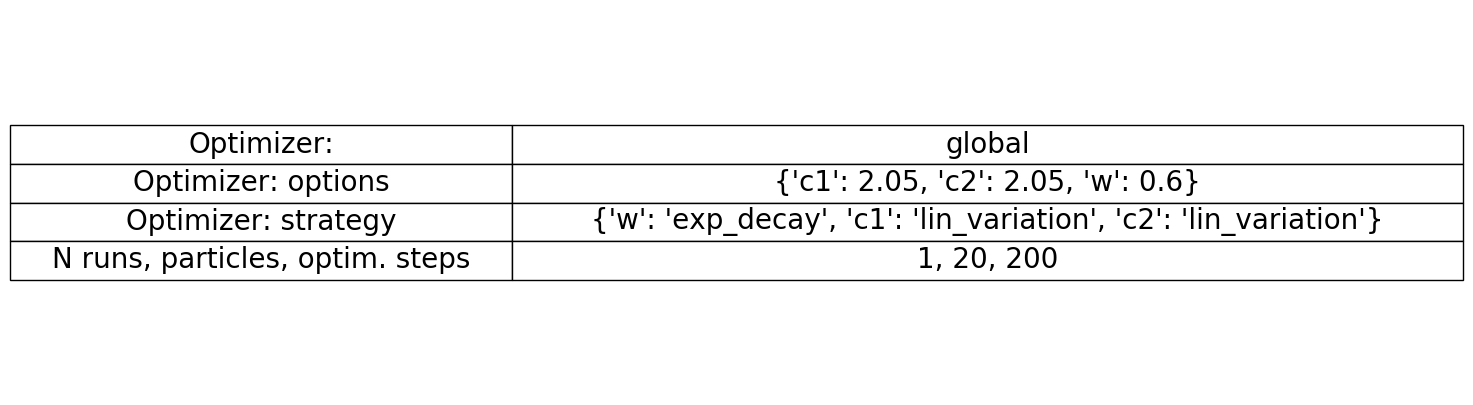

In [25]:
if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with machine params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(14,5))
row_height=0.1; col_width=0.7

# Table with machine, inputs params
timing = 'daily' if freq=='d' else 'hourly'
calib = 'sigma0' if opt_calib=='1' else 'sigma0+sm'
nruns = str(nrun)
n_particles = 20
n_step = 200
cellText = [
    # ['Units', units],
    # ['Cost function', opt_cost],
    # ['Calib on', calib],
    ['Optimizer:', optim],
    ['Optimizer: options', options],
    ['Optimizer: strategy', oh_strategy],
    ['N runs, particles, optim. steps', str(nrun)+', '+str(n_particles)+', '+str(n_step)],
    # ['Time frequency', timing],
    # ['Vegetation descriptor', opt_veg],
]
table = ax.table(cellText=cellText,
                     cellLoc='center', loc='center',
                     colLabels=None, rowLabels=None)

for (row, col), cell in table.get_celld().items():
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_str))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{year}_table_mach.png', dpi=100)
plt.show()

# Parameters' study

In [20]:
raise NameError('stop')

NameError: stop

In [26]:
PAR_dict_2017_PB_1={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.303, 0.085, np.array([0.36240038, 0.34961977, 0.55686897, 0.34521662, 0.34069458,
       0.36104542, 0.34514568, 0.33556688, 0.35387662, 0.3449015 ,
       0.35706967, 0.37473151, 0.35899694, 0.35139686, 0.36328476,
       0.35190716, 0.34567647, 1.1404246 , 0.34546263, 0.33685938,
       0.33873493, 0.34185161, 0.33756989, 0.33166807, 0.34253743,
       0.38865606, 1.37444488, 0.34098593, 0.36418443, 0.34286239,
       0.34915181, 0.34499012, 0.34912246, 0.40763463, 0.31897422,
       0.34992391, 0.3412348 , 0.35113869, 0.35131136, 0.34705154,
       0.34036838, 0.34631095, 0.32261748, 0.35612803, 0.34580806,
       0.34738394, 0.34269778, 0.35066889, 0.36891261, 0.34179665,
       2.53794527, 0.34315898, 0.74521373, 0.34355781, 0.34860201,
       0.344758  , 0.35035367, 0.34761446, 0.58275811, 0.34579888,
       0.34393728, 0.3508277 , 0.36305718, 0.35584528, 0.34684429,
       0.32711761, 0.34562335, 0.34478673, 0.96365981, 0.33373035,
       0.46658065, 0.34836214, 0.34628225, 0.35607131, 0.34146342,
       0.36822429, 0.34195814, 0.35100608, 0.3027462 , 0.34237155,
       0.34700336, 0.45901569, 0.34093367, 0.34498305, 0.35528033,
       0.36438533, 0.46123899, 0.35458073, 0.33625284, 0.34668185,
       0.35507917, 0.3608338 , 0.34523526, 0.36244123, 0.34699563,
       1.47343956, 0.34324503, 0.32388007, 0.34775315, 0.34766217])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.55, 0.12, np.array([0.6049739 , 0.67299302, 0.24399227, 0.70720688, 0.73939762,
       0.60453532, 0.69845894, 0.89070535, 0.64736911, 0.70307236,
       0.63187729, 0.56917383, 0.60650066, 0.6553521 , 0.61277711,
       0.66022681, 0.71911001, 0.11914565, 0.69466205, 0.76617453,
       0.80001111, 0.71061132, 0.75161604, 0.75764607, 0.94543704,
       0.49561473, 0.06994013, 0.74448374, 0.77767628, 0.71769646,
       0.67259853, 0.70784164, 0.67359502, 0.37734868, 1.29816508,
       0.66327824, 0.74732676, 0.66068284, 0.6559047 , 0.68797694,
       0.74805837, 0.69945511, 0.86672866, 0.63813575, 0.69971412,
       0.68053475, 0.71210359, 0.66079092, 0.59883128, 0.74625369,
       0.0349462 , 0.7212248 , 0.15150228, 0.72157105, 0.67637599,
       0.69771469, 0.67331425, 0.68506344, 0.23079697, 0.69351598,
       0.70786043, 0.84444997, 0.59582683, 0.6383405 , 0.69439993,
       1.00520953, 0.69899147, 0.71602599, 0.14493557, 0.75758955,
       0.3480443 , 0.68246358, 0.69470579, 0.63383175, 0.79391139,
       0.61160101, 0.70753283, 0.66776571, 1.43860007, 0.88295514,
       0.88773378, 0.35660772, 0.71586854, 0.7191156 , 0.63564114,
       0.58633378, 0.35315748, 0.65464309, 0.79180025, 0.81376948,
       0.64134078, 0.7857498 , 0.70168332, 0.62589556, 0.68669676,
       0.06547068, 0.7151825 , 2.43794384, 0.68270623, 0.87705648])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -14.57, 0.187, np.array([-14.6097775 , -14.50079625, -14.59518377, -14.38056948,
       -14.36601507, -14.41675115, -14.51356597, -17.10141414,
       -14.56066958, -14.53404492, -14.39409402, -14.24234537,
       -14.39696496, -14.56225247, -14.29681686, -14.5178093 ,
       -14.84499145, -18.79370948, -14.532293  , -14.56494538,
       -16.7704568 , -14.47885706, -14.58639344, -14.76548987,
       -19.15746222, -14.65952709, -14.77003498, -14.78021991,
       -18.74287972, -14.40089614, -14.41188952, -14.4701099 ,
       -14.51725557, -14.628399  , -20.39112177, -14.47230427,
       -14.82714566, -14.53608247, -14.51397059, -14.50804139,
       -14.48970384, -14.53165051, -15.75185571, -14.42674247,
       -14.37486398, -14.5723337 , -14.35733462, -14.53977603,
       -14.49670612, -14.49454168, -14.7859891 , -14.49266705,
       -14.76302325, -14.48834493, -14.51253669, -14.51888052,
       -14.51691139, -14.53907958, -14.57383827, -14.53543741,
       -14.42803855, -19.11391666, -14.59836334, -14.45475601,
       -14.4485128 , -19.33741671, -14.52789684, -14.39523101,
       -18.78648954, -14.81762773, -14.56278011, -14.53415292,
       -14.53323701, -14.39000411, -16.8330386 , -15.90556804,
       -14.54558563, -14.38003561, -19.46739981, -19.06916861,
       -19.13207535, -14.5561311 , -14.54174789, -14.49879131,
       -14.59524373, -14.46394645, -14.58637043, -14.32164139,
       -14.75272589, -17.63496549, -14.3970001 , -19.03052931,
       -14.53527484, -14.43426581, -14.52605427, -14.58410374,
       -14.37452407, -19.89240561, -14.52078823, -19.16953476])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 26.881, 1.815, np.array([28.92981858, 29.29950636, 24.77323713, 28.24233709, 28.25727027,
       27.6364422 , 28.57830089, 39.98152209, 30.01193208, 30.67297376,
       26.52431977, 25.8245728 , 27.91991863, 28.04540539, 26.00518397,
       27.22466547, 29.42727231, 39.74819045, 29.50553967, 33.05676448,
       38.4884809 , 28.87120744, 30.6575082 , 29.8370671 , 46.66658551,
       29.28184929, 26.97327083, 29.17198926, 39.29528885, 30.111345  ,
       27.56264636, 27.76959302, 27.60042812, 27.27134402, 52.33510658,
       30.05624623, 30.32122542, 29.63288906, 27.29904244, 27.72559378,
       30.40232881, 31.03471188, 36.39733776, 28.02559964, 27.22249381,
       30.62469234, 26.83718301, 28.72250966, 27.80709122, 32.09831967,
       27.51534921, 27.77629729, 26.76448827, 28.07373216, 28.17247605,
       28.56167843, 30.25844137, 30.49260565, 24.99480659, 29.56166139,
       28.30880626, 46.03316287, 28.78939048, 29.24158808, 29.67904118,
       47.40826723, 29.45501451, 31.16776467, 39.62769081, 30.36291722,
       28.35965233, 30.4757295 , 30.57903639, 27.38313939, 38.58231477,
       35.28687539, 30.65053764, 27.60850107, 50.12164682, 46.04713924,
       46.27756688, 25.15040846, 30.14497882, 30.20991088, 30.91033974,
       28.31565717, 26.42122217, 26.24672528, 30.13581706, 41.1958864 ,
       26.49896545, 45.0191304 , 31.61513469, 28.84848005, 29.22193654,
       25.3094958 , 28.00841122, 57.43634442, 29.0815479 , 46.28171451])],
r'$\delta_0$':['$[mm]$', 'fix', ['/', '/'], 1, '/'],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.29, 0.35], 0.315, 0.036, np.array([0.32480179, 0.31876992, 0.34840529, 0.33025073, 0.33213678,
       0.32978962, 0.33086406, 0.29006861, 0.31379245, 0.30947517,
       0.34607752, 0.3496617 , 0.32877994, 0.3350276 , 0.3496866 ,
       0.34455806, 0.32402148, 0.29017014, 0.32090777, 0.29402239,
       0.29000333, 0.32699648, 0.314377  , 0.3226548 , 0.29012924,
       0.31125359, 0.3157104 , 0.32874891, 0.32599716, 0.31116386,
       0.33844189, 0.33744662, 0.34092385, 0.3231061 , 0.29010023,
       0.30945848, 0.31423072, 0.31901482, 0.34314816, 0.34014563,
       0.31364897, 0.3038214 , 0.29038273, 0.33123735, 0.34164139,
       0.31080191, 0.34664923, 0.32745772, 0.33313853, 0.2983899 ,
       0.30684672, 0.33935981, 0.31998178, 0.33575306, 0.33398421,
       0.33120024, 0.31106122, 0.31025262, 0.34622304, 0.32022362,
       0.33134343, 0.29000232, 0.32684777, 0.31831144, 0.31587307,
       0.29022062, 0.32189809, 0.30085421, 0.29296136, 0.31835491,
       0.31329018, 0.31014826, 0.30987172, 0.33521161, 0.29097747,
       0.29200724, 0.30982967, 0.33505406, 0.29041534, 0.29002894,
       0.29001775, 0.34963314, 0.31542961, 0.31432048, 0.30419734,
       0.32739336, 0.33643529, 0.34932685, 0.32116272, 0.29001375,
       0.34631966, 0.29001288, 0.30018142, 0.32165341, 0.32333535,
       0.32581028, 0.33334317, 0.2900097 , 0.32439717, 0.290013  ])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.06, 0.12], 0.095, 0.004, np.array([0.10108194, 0.09215281, 0.10378105, 0.09360568, 0.0940507 ,
       0.09275594, 0.10003501, 0.11686581, 0.09514173, 0.09400264,
       0.09762301, 0.09792311, 0.09330868, 0.10161193, 0.09818811,
       0.10415837, 0.09393205, 0.11901108, 0.09717305, 0.09216235,
       0.11251079, 0.09761242, 0.09862148, 0.09792893, 0.11807446,
       0.09125323, 0.09890155, 0.09891655, 0.11999392, 0.08858263,
       0.09880836, 0.09744616, 0.10326506, 0.10215512, 0.1195768 ,
       0.08815164, 0.08964344, 0.09856339, 0.10356515, 0.10313748,
       0.09532154, 0.08924598, 0.11155361, 0.0973801 , 0.09651157,
       0.09698226, 0.09780483, 0.0993612 , 0.0994028 , 0.09026992,
       0.09633608, 0.09886593, 0.10173313, 0.09792238, 0.10130025,
       0.10047672, 0.0940062 , 0.0942392 , 0.1038881 , 0.09722043,
       0.09658185, 0.11906258, 0.10157144, 0.09350363, 0.09213306,
       0.11825938, 0.09771328, 0.08603156, 0.11950094, 0.09612316,
       0.09388016, 0.09406841, 0.09399969, 0.09492804, 0.11912256,
       0.11923764, 0.09398416, 0.09483018, 0.11539745, 0.11631146,
       0.1195322 , 0.10205408, 0.09580137, 0.0954913 , 0.09182466,
       0.09808979, 0.10075657, 0.09791691, 0.09700905, 0.11968875,
       0.09762636, 0.11764647, 0.09072718, 0.09447256, 0.09813829,
       0.09235422, 0.09440121, 0.11606935, 0.09817217, 0.11969837])],
r'$\rho_{st}$':['$[mm/h]$', 'fix', ['/', '/'], 0.4, '/'],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.279, 0.006, np.array([0.29284152, 0.27570966, 0.29824737, 0.28310791, 0.28295001,
       0.28280535, 0.28334588, 0.12978941, 0.28458525, 0.28489821,
       0.28193716, 0.29296238, 0.30443136, 0.28334039, 0.28182477,
       0.28166246, 0.21637259, 0.09936167, 0.28402172, 0.29543178,
       0.13205057, 0.28304173, 0.282892  , 0.28409339, 0.09979527,
       0.2724196 , 0.31335674, 0.22956851, 0.10035154, 0.28457979,
       0.29152415, 0.27092528, 0.28297389, 0.29610864, 0.0964849 ,
       0.28472502, 0.21448235, 0.29293806, 0.28264491, 0.28307637,
       0.28497468, 0.27358915, 0.1747776 , 0.29323401, 0.28227463,
       0.29351128, 0.28197244, 0.28372501, 0.28261815, 0.28554171,
       0.31409253, 0.27106056, 0.3047404 , 0.27129391, 0.28338825,
       0.28353823, 0.2848217 , 0.28485685, 0.30331426, 0.28418116,
       0.28273162, 0.10007726, 0.29265056, 0.29299473, 0.28343941,
       0.10001316, 0.28406084, 0.28552513, 0.10002893, 0.23011352,
       0.30525034, 0.28477795, 0.28481566, 0.28288484, 0.13071152,
       0.16995971, 0.28480702, 0.28274187, 0.09960912, 0.10123234,
       0.10080209, 0.29410922, 0.28449497, 0.28470399, 0.28496387,
       0.30442285, 0.28289659, 0.28146802, 0.22994196, 0.11682021,
       0.28196546, 0.0997862 , 0.28530084, 0.29305982, 0.28396644,
       0.30471572, 0.28288794, 0.0954715 , 0.28376856, 0.1002614 ])],
}


#----------------------------------------------------------------------


PAR_dict_2017_PB_2={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.322, 0.141, np.array([0.3461318 , 2.04557702, 0.32189167, 0.35288022, 0.34267223,
       0.36126974, 2.0375678 , 0.34843345, 0.34725139, 0.34577237,
       0.3581536 , 0.34522596, 0.42953443, 0.3468915 , 0.36435841,
       0.34901522, 0.3293012 , 0.35308371, 0.7381299 , 0.37887689,
       0.80337262, 0.34045867, 0.34708799, 0.35125252, 0.34485901,
       2.41062966, 0.37927735, 0.36788967, 0.34738943, 0.33152823,
       0.35587297, 0.35261686, 0.3461482 , 0.33475215, 1.44464722,
       1.09027775, 0.34209077, 0.34093597, 0.35804653, 0.34366159,
       0.34486255, 0.34568306, 0.34698193, 0.34545659, 0.34312266,
       0.3439516 , 0.35632768, 0.37379166, 0.34837915, 0.34237587,
       0.34461984, 0.34872981, 0.35128808, 0.3461374 , 0.64891221,
       0.37358402, 0.321607  , 0.34251246, 0.35267062, 0.34251333,
       0.34672497, 0.33602649, 0.34921941, 0.33687442, 0.34624001,
       0.65711233, 0.38271268, 0.35160675, 0.34413849, 0.34693201,
       0.33992095, 0.34959719, 0.33860645, 0.3440105 , 0.34568992,
       0.34266411, 0.34198138, 0.34283769, 0.34658744, 1.8261565 ,
       0.36453832, 0.72925241, 0.35067497, 0.34470151, 0.34611997,
       0.3423282 , 0.34445276, 0.34868789, 0.3447822 , 0.36822896,
       0.33124533, 2.46473296, 0.37018434, 3.99482822, 0.34563207,
       0.3523274 , 0.33027739, 0.3450028 , 0.34250348, 0.34625675])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.642, 0.094, np.array([0.69490861, 0.04362703, 1.62365164, 0.66516398, 0.71436751,
       0.61389585, 0.0593101 , 0.67621874, 0.68702644, 0.69368557,
       0.6253421 , 0.71208031, 0.39678955, 0.69533082, 0.58162604,
       0.86918048, 0.57575059, 0.6684624 , 0.16075643, 0.53108683,
       0.14215534, 0.73264408, 0.86973932, 0.65841983, 0.70566893,
       0.03730029, 0.52665062, 0.57700871, 0.68473616, 0.95129969,
       0.62874176, 0.65158369, 0.70040984, 0.78340897, 0.06644374,
       0.09340993, 0.77571147, 0.71498402, 0.61667345, 0.71568799,
       0.71070393, 0.69945153, 0.69213808, 0.72488985, 0.71819964,
       0.7008813 , 0.64630099, 0.56840368, 0.6827643 , 0.71368716,
       0.703021  , 0.68122434, 0.67831654, 0.69516609, 0.1867026 ,
       0.54784636, 0.92253937, 0.91358558, 0.68292002, 0.71484007,
       0.6868186 , 0.90723178, 0.68277883, 0.73308101, 0.69970884,
       0.18726513, 0.64901189, 0.83624153, 0.91482561, 0.68928112,
       0.7620433 , 0.67055794, 0.77696515, 0.72482701, 0.70367656,
       0.70161616, 0.72758816, 0.71540035, 0.70067797, 0.05047133,
       0.62469604, 0.20568095, 0.66966594, 0.6922571 , 0.69504741,
       0.72786477, 0.71997015, 0.67597972, 0.70520009, 0.61515742,
       1.10221996, 0.03648332, 0.55740918, 0.02176733, 0.70165134,
       0.65271571, 0.81547532, 0.82465974, 0.72067882, 0.69055916])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -14.729, 0.297, np.array([-14.53813778, -14.69915186, -21.23623458, -14.47067602,
       -14.54856446, -14.50761743, -18.69344426, -14.44266148,
       -14.49339895, -14.54557206, -14.4528244 , -14.46584769,
       -14.62927567, -14.46391447, -14.58798474, -18.99013455,
       -14.70447433, -14.78532627, -14.71442759, -14.48187335,
       -14.67956017, -14.36404855, -19.25353835, -14.59854113,
       -14.39989194, -14.58625501, -14.42735738, -14.4816725 ,
       -14.51960637, -19.21580986, -14.51231755, -14.39484077,
       -14.47401555, -14.43958266, -14.68910562, -14.72256231,
       -16.71255065, -14.47175165, -14.40738768, -14.47115947,
       -14.49383045, -14.36858215, -14.58345388, -14.75054263,
       -14.49047588, -14.45220818, -14.50989984, -14.591919  ,
       -14.51044621, -14.58392983, -14.45086387, -14.39921243,
       -14.46732445, -14.535133  , -14.6672215 , -14.59273251,
       -14.72147096, -19.30066067, -14.351959  , -14.38176462,
       -14.51594819, -17.93300571, -14.50666973, -15.52452164,
       -14.40803387, -14.77747939, -18.90048164, -19.05349209,
       -19.05377287, -14.52679267, -14.47434974, -14.52950374,
       -14.71922783, -14.50830517, -14.54152339, -14.40397841,
       -14.46438333, -14.50494727, -14.47206686, -14.65618261,
       -14.23942059, -18.81516366, -14.43237944, -14.55077406,
       -14.51622365, -14.50684604, -14.52648792, -14.51320393,
       -14.4839371 , -16.83763135, -19.33313244, -14.70592638,
       -14.45647983, -14.67187933, -14.45215857, -14.41437505,
       -14.81477917, -16.59078381, -14.36190808, -14.48927896])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 26.74, 2.109, np.array([30.80238843, 26.28165495, 57.03022222, 30.34542535, 31.54947847,
       27.8487004 , 38.86541965, 27.33245904, 29.2811006 , 31.63827106,
       28.50977665, 29.68496512, 26.98190386, 28.7358963 , 27.46071997,
       45.75983757, 27.49128231, 28.24037516, 26.70214501, 26.88067097,
       24.6480413 , 28.09136353, 46.15076708, 31.4837985 , 30.07827926,
       24.47018406, 25.94150751, 28.67195756, 28.86802548, 46.7567707 ,
       26.63546682, 27.58635329, 29.55368163, 27.95701708, 25.68591372,
       26.40385404, 35.7076235 , 30.89421916, 27.37401456, 27.94404475,
       30.37048219, 27.30270588, 30.99176142, 30.79732425, 30.23428328,
       27.54249194, 27.93639715, 26.86401373, 28.41578682, 29.15680776,
       27.69421475, 28.81332562, 28.20909493, 30.26461411, 27.04953469,
       28.96464265, 29.77676026, 46.88562678, 27.18239268, 28.43957852,
       28.28071119, 42.78257035, 30.29328687, 30.49213997, 29.87984881,
       26.75916702, 44.06521839, 45.56707966, 46.26315091, 29.52044343,
       29.81881851, 29.29678246, 32.84611962, 30.98018442, 31.16559744,
       27.71580669, 27.07744757, 29.56889137, 29.6523671 , 25.68115242,
       28.87863274, 40.41809881, 27.7627247 , 29.06735838, 29.39798663,
       30.20776419, 31.74434474, 28.58407198, 27.29022879, 37.15521089,
       48.30564927, 26.10125309, 26.1590164 , 26.90351933, 28.09031554,
       28.35722785, 30.12777167, 37.7306656 , 27.4772595 , 27.91508421])],
r'$\delta_0$':['$[mm]$', 'fix', ['/', '/'], 1, '/'],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.29, 0.35], 0.323, 0.035, np.array([0.30771287, 0.31703723, 0.29003879, 0.30782203, 0.30149719,
       0.33286274, 0.29004686, 0.34072481, 0.32122281, 0.2995749 ,
       0.32575993, 0.31644921, 0.33138029, 0.32821094, 0.33583886,
       0.29000305, 0.34371213, 0.33427319, 0.32341794, 0.33888656,
       0.34584274, 0.33334461, 0.29101829, 0.30178251, 0.31077479,
       0.33458139, 0.34821966, 0.32037734, 0.32693517, 0.29000991,
       0.34910119, 0.33458128, 0.31725451, 0.33958331, 0.32590201,
       0.32060221, 0.30933281, 0.30499091, 0.3335908 , 0.3359504 ,
       0.30980736, 0.34050634, 0.30521503, 0.30515465, 0.31146067,
       0.34132878, 0.33513069, 0.34709485, 0.33167805, 0.32804713,
       0.33947523, 0.32253261, 0.33301901, 0.31294368, 0.31679909,
       0.32084386, 0.33073057, 0.2900436 , 0.34210626, 0.32807596,
       0.33365627, 0.29006152, 0.31149035, 0.32937593, 0.3128744 ,
       0.32425977, 0.29004112, 0.29015967, 0.29002869, 0.32027352,
       0.32059886, 0.32149957, 0.2913014 , 0.30407566, 0.30513987,
       0.33792061, 0.34752735, 0.32040491, 0.31619224, 0.32381908,
       0.31695198, 0.29112171, 0.33534868, 0.32625822, 0.32167923,
       0.31489702, 0.30057688, 0.32922595, 0.34385061, 0.29141982,
       0.29000006, 0.31889305, 0.34927794, 0.30612787, 0.33311326,
       0.32553384, 0.32313556, 0.29454874, 0.33975236, 0.33715356])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.06, 0.12], 0.095, 0.005, np.array([0.09349344, 0.09508147, 0.11915583, 0.08954886, 0.0915777 ,
       0.0996893 , 0.11980759, 0.09949068, 0.09550169, 0.09057984,
       0.09547445, 0.09114865, 0.10113325, 0.09891293, 0.09839565,
       0.11976098, 0.0940648 , 0.09983044, 0.09903962, 0.09885731,
       0.1034149 , 0.09439258, 0.1181926 , 0.09422561, 0.08861009,
       0.09476291, 0.10160308, 0.09404753, 0.09920208, 0.11891945,
       0.10405761, 0.09477633, 0.09170444, 0.09851262, 0.09752622,
       0.09844361, 0.11742088, 0.0890473 , 0.09447523, 0.09701921,
       0.08933176, 0.09617782, 0.09102612, 0.08169242, 0.08964578,
       0.10240343, 0.1014737 , 0.10786619, 0.10026979, 0.10226208,
       0.10015036, 0.09163724, 0.10038566, 0.0950187 , 0.09375496,
       0.10087643, 0.09932336, 0.11816286, 0.09912941, 0.09281715,
       0.10120675, 0.11907719, 0.09423473, 0.11046518, 0.08918171,
       0.10154127, 0.11942429, 0.11959266, 0.11922888, 0.09722469,
       0.09730076, 0.09729996, 0.08182721, 0.08675322, 0.09261323,
       0.09857384, 0.10094663, 0.09634566, 0.09135625, 0.0970419 ,
       0.089555  , 0.11972525, 0.09747848, 0.09863845, 0.09739837,
       0.09544814, 0.09131673, 0.09956221, 0.10055893, 0.11985535,
       0.11773797, 0.0956085 , 0.10139395, 0.0918064 , 0.09623666,
       0.09251029, 0.09954443, 0.10902872, 0.09602922, 0.10095543])],
r'$\rho_{st}$':['$[mm/h]$', 'fix', ['/', '/'], 0.4, '/'],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.273, 0.007, np.array([0.28502396, 0.30511164, 0.08898334, 0.28397534, 0.28545277,
       0.28280136, 0.10104366, 0.2825548 , 0.28275879, 0.2853879 ,
       0.29245125, 0.27261454, 0.29144428, 0.28335334, 0.27143212,
       0.10135099, 0.30554917, 0.22927182, 0.30476104, 0.29149656,
       0.30317554, 0.28287765, 0.09985424, 0.29424017, 0.28467943,
       0.30412773, 0.28227209, 0.29283029, 0.28374968, 0.10071388,
       0.28174134, 0.28295962, 0.27569889, 0.27103206, 0.3045239 ,
       0.3049618 , 0.13021799, 0.28423201, 0.28289993, 0.27099077,
       0.27303287, 0.28233438, 0.27317606, 0.21655279, 0.27217788,
       0.28150761, 0.28322636, 0.29145121, 0.28329393, 0.28385415,
       0.28332245, 0.28374227, 0.28307484, 0.2846648 , 0.3050972 ,
       0.29453703, 0.22948317, 0.09986272, 0.27824759, 0.28316633,
       0.28340306, 0.11440011, 0.28457325, 0.17390535, 0.28454859,
       0.29288336, 0.10211699, 0.10070407, 0.10065839, 0.28416473,
       0.28425748, 0.28395021, 0.23095178, 0.2660218 , 0.2851437 ,
       0.29143125, 0.27054468, 0.28374331, 0.27572474, 0.30476345,
       0.30527875, 0.0997882 , 0.28240348, 0.28587135, 0.28399957,
       0.28445766, 0.28550909, 0.2834454 , 0.27082655, 0.13087455,
       0.09977408, 0.30494147, 0.29084717, 0.30595591, 0.275038  ,
       0.28376067, 0.23672384, 0.13092019, 0.2824068 , 0.28253742])],
}


#----------------------------------------------------------------------


PAR_dict_2020_PB_1 ={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.178, 0.106, np.array([0.23008243, 0.34156009, 0.18498048, 0.2309923 , 0.43203446,
       0.44581302, 0.18829538, 0.19107326, 0.39941698, 0.19233765,
       0.20399505, 0.18192903, 0.180094  , 0.18567104, 0.8717832 ,
       0.23874084, 1.04154669, 0.45660398, 1.08240387, 0.18577512,
       0.89162465, 0.77248627, 0.37023848, 0.1798478 , 0.18428905,
       0.59132601, 0.29360325, 2.09675237, 0.21243045, 0.1980925 ,
       0.1804169 , 0.50219246, 0.20950309, 0.1932256 , 0.25282552,
       0.30831328, 0.24280972, 0.20520225, 0.18177608, 0.47554638,
       2.11631126, 0.18077292, 0.24319315, 0.20495457, 0.48798641,
       0.20726813, 0.21026151, 0.18034373, 0.18041784, 0.21271785,
       0.18292929, 0.32183323, 0.25003474, 0.17964549, 0.18112862,
       0.18302299, 0.18124277, 1.57244423, 0.69732827, 0.18281634,
       0.73882928, 0.18740736, 0.18390801, 0.23692379, 0.24590809,
       0.17983517, 0.28718591, 0.18142523, 0.18406372, 0.40311635,
       1.46766172, 0.18922127, 0.18462178, 0.21650842, 0.58117058,
       0.17957028, 0.3707675 , 0.21274408, 0.18077383, 0.19186133,
       0.51290488, 0.2719729 , 0.46050187, 0.2051401 , 1.08882047,
       0.1801694 , 1.39608433, 0.40909822, 0.18371109, 0.18220249,
       0.53554464, 0.18430711, 0.19304496, 0.20646321, 0.18387124,
       0.17760252, 0.42425992, 1.7886781 , 0.63140398, 0.2218338 ])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.027, 0.547, np.array([0.47527295, 0.23406965, 1.23671721, 0.49577996, 0.16420259,
       0.18831159, 1.02387553, 0.8197856 , 0.18778854, 0.78007997,
       0.70066192, 1.8731969 , 1.52473842, 2.00044701, 0.07101789,
       0.49073657, 0.05859876, 0.15730776, 0.05589979, 0.99561851,
       0.06876696, 0.08135518, 0.21116785, 1.9160512 , 1.25699396,
       0.1299141 , 0.33471517, 0.02723622, 0.61285683, 0.74605562,
       1.7829493 , 0.13922418, 0.62161631, 0.82968652, 0.40276797,
       0.29406545, 0.44067231, 0.68287052, 1.80421147, 0.14827323,
       0.02685408, 1.83315328, 0.43725083, 0.64616874, 0.14041139,
       0.62582687, 0.63680003, 2.33852836, 2.84609114, 0.61070891,
       1.9363455 , 0.25778553, 0.41830675, 2.13900916, 1.67371342,
       1.55346665, 1.36361452, 0.03743052, 0.09228705, 2.09730956,
       0.08678431, 0.94575869, 1.33113847, 0.45072903, 0.42352289,
       1.45757799, 0.31632599, 1.41110581, 1.95322927, 0.18569346,
       0.04517236, 0.83502399, 1.35614067, 0.61139163, 0.13121731,
       1.9381909 , 0.2115644 , 0.59565313, 2.20337297, 0.83749123,
       0.13630973, 0.34691373, 0.1554238 , 0.66522294, 0.05484559,
       2.60537301, 0.04153769, 0.17677831, 1.1009127 , 2.45742413,
       0.12923301, 1.23394927, 0.84042334, 0.64490601, 1.75176752,
       1.8896301 , 0.17406624, 0.03239984, 0.10300588, 0.51699113])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -17.805, 0.312, np.array([-17.44116652, -17.47881023, -16.96879093, -17.26939774,
       -17.55680293, -24.31263007, -17.18064461, -17.3912985 ,
       -17.97052777, -17.44416076, -17.3418186 , -16.59105157,
       -16.90189199, -16.38631561, -17.95949592, -20.746307  ,
       -17.52516626, -17.97225048, -17.9187243 , -17.20244144,
       -17.24343648, -17.14269631, -17.9356274 , -20.55592555,
       -17.06421991, -20.45630221, -20.985379  , -17.96706007,
       -17.36818064, -17.36590062, -16.749824  , -17.10189176,
       -22.29425423, -23.15908238, -17.68639519, -17.74691548,
       -17.42214011, -17.3605077 , -16.74326763, -17.96419423,
       -17.21160503, -16.76508907, -17.41856486, -20.88867971,
       -17.52403844, -17.41194761, -20.87403368, -25.47009041,
       -16.92403823, -17.43832125, -16.66394942, -17.46270893,
       -17.3642122 , -25.22493838, -16.72726393, -16.72129198,
       -17.57302705, -17.13078979, -17.95930768, -16.46092212,
       -17.1167287 , -17.24006611, -16.9041093 , -17.44869545,
       -17.96124983, -16.97245752, -17.93545941, -16.93720388,
       -16.94468347, -17.93827286, -21.03460273, -17.29893022,
       -16.90961718, -20.29435404, -21.80994727, -16.6776465 ,
       -17.05325958, -17.90613396, -16.48126215, -17.36704933,
       -17.81674379, -17.43652038, -17.10462007, -17.33151777,
       -17.25489696, -25.85964368, -17.29081742, -17.54625112,
       -17.70497228, -16.43165093, -17.08636312, -17.08824915,
       -17.26356233, -17.35525901, -16.62931633, -16.70518983,
       -17.95151061, -17.96079255, -17.14634146, -17.39431291])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 25.288, 8.648, np.array([30.89644807, 26.23431228, 34.32808889, 29.27551244, 27.05764043,
       48.30416468, 34.50373476, 33.12330747, 28.99610465, 32.22836261,
       31.52980426, 37.90421242, 34.94166623, 36.54489109, 25.53495023,
       38.91273622, 26.31276359, 27.65347929, 25.6338336 , 32.48325901,
       25.99896573, 24.74128621, 25.75579739, 48.0541072 , 32.61184227,
       32.4932093 , 35.45098261, 25.30712536, 32.43081251, 32.06546197,
       34.73833479, 24.94576294, 43.21779664, 44.8620876 , 30.26168568,
       28.17597997, 29.34556027, 31.03631892, 39.33894337, 29.06802929,
       27.56631141, 39.69657633, 29.28739887, 40.55458358, 29.85417555,
       33.27176998, 38.09322812, 66.21220319, 46.22886638, 32.58837584,
       40.59464455, 27.25407557, 28.13454088, 62.35847057, 35.12267799,
       37.75388637, 35.67572675, 26.92458463, 26.83305809, 38.34792618,
       26.99918015, 33.22298779, 34.14290491, 29.8537405 , 29.65607088,
       34.87545063, 29.72173747, 36.88899696, 40.28812614, 27.40666778,
       34.78221395, 33.82570468, 34.90423971, 35.06910432, 36.56794185,
       38.776182  , 26.4786181 , 31.35415669, 38.04140433, 32.8168252 ,
       26.82069917, 28.7840516 , 26.87403932, 33.01603385, 25.69943178,
       69.42450957, 28.30682871, 28.0412065 , 36.31199898, 40.5005015 ,
       27.99037899, 36.76138331, 33.58287159, 28.63591475, 34.41679932,
       36.18474616, 27.92281572, 25.27933017, 28.7762944 , 29.70026632])],
r'$\delta_0$':['$[mm]$', 'fix', ['/', '/'], 1, '/'],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.29, 0.35], 0.309, 0.02, np.array([0.31077   , 0.34501536, 0.31237264, 0.32429417, 0.33820087,
       0.29034812, 0.30074902, 0.30671921, 0.30830679, 0.31337675,
       0.32081246, 0.30654097, 0.31994138, 0.32228716, 0.33872713,
       0.29168978, 0.32980369, 0.32075694, 0.33245236, 0.31947957,
       0.33317845, 0.34852537, 0.34807571, 0.29736653, 0.32842384,
       0.31424204, 0.31513777, 0.33790603, 0.30464765, 0.31325303,
       0.33351158, 0.34882801, 0.29912866, 0.31783024, 0.31113377,
       0.32306899, 0.32947718, 0.32268477, 0.29269851, 0.30477833,
       0.3110175 , 0.29329269, 0.32507551, 0.29063257, 0.30076001,
       0.29753924, 0.30680207, 0.2998988 , 0.29109628, 0.30843097,
       0.29171522, 0.33926803, 0.3371707 , 0.30712978, 0.32311549,
       0.2944556 , 0.30743274, 0.31787556, 0.32463803, 0.31526695,
       0.32038409, 0.31360032, 0.31931842, 0.32299292, 0.31814766,
       0.31688884, 0.31045273, 0.29714149, 0.29758527, 0.32607181,
       0.30071411, 0.29690377, 0.31502623, 0.31976414, 0.31126017,
       0.30222475, 0.3333524 , 0.31031986, 0.31951518, 0.3093696 ,
       0.32301448, 0.32534669, 0.32518615, 0.30225054, 0.33636632,
       0.30008408, 0.30551395, 0.32464338, 0.29212388, 0.31537392,
       0.31033874, 0.29140699, 0.30315333, 0.34396563, 0.33406387,
       0.32282994, 0.31859366, 0.33893304, 0.30168749, 0.3243067 ])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.06, 0.12], 0.118, 0.019, np.array([0.10994509, 0.10732252, 0.11644681, 0.11881318, 0.10774407,
       0.0775578 , 0.11322319, 0.11533016, 0.09694484, 0.11126516,
       0.11267133, 0.11424811, 0.11904738, 0.11847571, 0.10616477,
       0.08347913, 0.09413139, 0.10029294, 0.10401467, 0.11636216,
       0.0833994 , 0.08276863, 0.1088961 , 0.09027309, 0.11600931,
       0.06094107, 0.09485372, 0.10405679, 0.10862992, 0.1100343 ,
       0.11660596, 0.08293777, 0.08929491, 0.09576649, 0.1004423 ,
       0.106144  , 0.11489384, 0.11335589, 0.110119  , 0.09601834,
       0.07555053, 0.11049662, 0.10841955, 0.09262913, 0.0947    ,
       0.10512741, 0.10035795, 0.09105789, 0.11054892, 0.1003767 ,
       0.10974788, 0.10698598, 0.10854633, 0.0921068 , 0.11861577,
       0.11104757, 0.11745216, 0.075424  , 0.09998503, 0.11588   ,
       0.07644749, 0.11524808, 0.11783019, 0.11351029, 0.1003332 ,
       0.11759578, 0.09760502, 0.09704793, 0.11925827, 0.10214595,
       0.08920407, 0.10933224, 0.11743825, 0.09711707, 0.09185257,
       0.1137022 , 0.07951958, 0.10479859, 0.11226271, 0.11364474,
       0.10139302, 0.10390019, 0.07768486, 0.1072818 , 0.08432642,
       0.06039081, 0.07722308, 0.10489358, 0.11579829, 0.11707402,
       0.07415303, 0.10946897, 0.10748591, 0.11861569, 0.11662743,
       0.11862386, 0.10002135, 0.10116963, 0.0708691 , 0.11483155])],
r'$\rho_{st}$':['$[mm/h]$', 'fix', ['/', '/'], 0.5, '/'],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.904, 0.05, np.array([0.91925357, 0.87481051, 0.91721459, 0.91713466, 0.90388911,
       0.14761593, 0.85187863, 0.85058473, 0.54780117, 0.81978934,
       0.91610802, 0.91840807, 0.91536247, 0.91818594, 0.54299242,
       0.22261971, 0.80032234, 0.5442223 , 0.54447301, 0.91541383,
       0.91514884, 0.91310119, 0.54172461, 0.25588226, 0.81566952,
       0.21822386, 0.20633292, 0.54222551, 0.9222046 , 0.91796293,
       0.91419515, 0.90929643, 0.18637529, 0.17418082, 0.67252692,
       0.54481055, 0.91394182, 0.91625817, 0.8529835 , 0.54773161,
       0.92086371, 0.85345716, 0.89096981, 0.22193918, 0.90663315,
       0.91373837, 0.2305642 , 0.16589909, 0.54564518, 0.91202278,
       0.85327273, 0.91148283, 0.90541293, 0.16577272, 0.91789078,
       0.9215726 , 0.5458407 , 0.91490937, 0.54480483, 0.91990008,
       0.91893656, 0.91967533, 0.91891109, 0.91631374, 0.5466445 ,
       0.84857805, 0.54749692, 0.91949994, 0.69136108, 0.54534866,
       0.19263682, 0.91430211, 0.91632391, 0.24416316, 0.17528328,
       0.85151431, 0.91606961, 0.54508398, 0.91673052, 0.85096531,
       0.54525194, 0.90499   , 0.91790168, 0.91362232, 0.91552509,
       0.16574859, 0.92191854, 0.90834055, 0.54705824, 0.84887877,
       0.92126366, 0.85276842, 0.92205413, 0.91065986, 0.9138072 ,
       0.91106645, 0.54548792, 0.54184578, 0.92055943, 0.91408924])],
}


#----------------------------------------------------------------------


PAR_dict_2020_PB_2 = {
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.179, 0.175, np.array([0.27815933, 0.23299656, 2.94564704, 0.18293342, 0.37660316,
       0.89798365, 0.18067105, 0.25507956, 0.21445278, 0.43367572,
       0.18013829, 0.18256584, 0.72285289, 0.18481512, 0.43193788,
       0.21698675, 0.18140974, 3.52970782, 0.18520515, 0.39861163,
       0.50931714, 0.19047348, 0.23013774, 0.22534121, 0.18384045,
       0.19077835, 0.61538117, 0.18111452, 0.52302101, 0.24938245,
       0.21375988, 0.28948253, 0.17924582, 0.38942975, 0.22367631,
       0.18235046, 0.2526237 , 0.22625082, 0.29037163, 0.20685212,
       0.25143044, 0.30708754, 0.24867235, 0.23609455, 0.18645484,
       0.21118175, 0.18019695, 1.06644852, 1.15606329, 0.43987557,
       0.19419214, 0.20888689, 0.24518189, 0.18168227, 0.1920755 ,
       0.21140757, 0.23525033, 0.18352822, 0.57318468, 0.4720474 ,
       0.2683513 , 0.88358108, 0.35063444, 0.18135062, 0.29574714,
       0.18218703, 0.18204885, 0.22581344, 0.18983692, 0.8107971 ,
       0.18156133, 0.20026357, 0.24812522, 0.41394364, 0.18065038,
       2.42104577, 0.54837228, 0.5192532 , 0.1825673 , 0.17995163,
       0.31775211, 0.17887528, 0.21191716, 0.18201215, 0.44123086,
       0.24484379, 0.18356283, 0.18072359, 4.10670236, 0.22309597,
       0.18419682, 0.5956666 , 0.18167305, 0.1830118 , 0.18114856,
       0.18217739, 0.18498251, 0.25013734, 0.29102027, 0.28346477])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.013, 0.608, np.array([0.3718394 , 0.5397972 , 0.01893612, 1.13712464, 0.23400153,
       0.06835567, 2.10915768, 0.38567107, 0.61294973, 0.16219926,
       2.61290752, 1.37716183, 0.08808033, 1.16829172, 0.16715124,
       0.58598719, 2.53470058, 0.01568082, 1.04616538, 0.1870356 ,
       0.13576641, 0.9387327 , 0.47914748, 0.51780021, 1.41384194,
       0.92814921, 0.1068124 , 1.32971674, 0.15510151, 0.42602221,
       0.63043758, 0.34407455, 2.90548101, 0.21504812, 0.50873783,
       1.24721666, 0.39039913, 0.58581888, 0.34103079, 0.61688797,
       0.39265103, 0.27594202, 0.41377622, 0.46539416, 1.09856473,
       0.64696525, 2.42112516, 0.05631321, 0.05189137, 0.1616485 ,
       0.86055784, 0.6721297 , 0.42677182, 1.33729775, 0.89073082,
       0.65172364, 0.51485342, 0.96734184, 0.13320921, 0.15235656,
       0.35438528, 0.06987179, 0.25493904, 1.57624503, 0.32978293,
       2.029884  , 1.61460996, 0.51395271, 0.84757573, 0.07437814,
       2.13193549, 0.73521083, 0.42305243, 0.17530004, 2.0097636 ,
       0.023266  , 0.12111396, 0.12942034, 1.60916692, 1.99600226,
       0.25780827, 1.84401831, 0.63208265, 1.65001104, 0.16533328,
       0.47561219, 1.60938757, 2.99029614, 0.01315204, 0.56811574,
       1.26067991, 0.11117329, 2.16797965, 1.15266165, 2.02572706,
       1.38596801, 0.95461579, 0.41296827, 0.31143746, 0.32416514])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -16.86, 0.955, np.array([-22.16878605, -22.47602579, -17.5200425 , -17.11645029,
       -21.19939459, -17.20313029, -17.34211492, -17.44621012,
       -22.94696068, -17.54476154, -19.77574459, -17.03139779,
       -17.97274311, -17.04909923, -17.52313468, -17.35066259,
       -16.98972223, -17.27293583, -17.41420967, -17.20201399,
       -17.2135749 , -17.18797957, -17.39491871, -17.41385742,
       -17.38936355, -17.25806504, -17.14196302, -16.9782764 ,
       -25.30032124, -22.80955257, -20.6025979 , -20.29199916,
       -21.67116701, -20.57959243, -17.4089048 , -17.13276709,
       -17.45351972, -22.6084485 , -22.09352895, -17.47298219,
       -17.55863487, -17.48926253, -17.88394538, -17.37811686,
       -17.14517047, -17.22071593, -19.57206462, -17.17855869,
       -17.1604486 , -17.35252257, -17.19233431, -17.27982492,
       -17.35016164, -17.0885819 , -17.76462605, -17.21960928,
       -22.92049071, -17.26050295, -20.72551394, -17.8556397 ,
       -17.41049205, -17.96910949, -22.48538543, -16.8121743 ,
       -21.34976766, -16.84962182, -17.45814647, -17.94801106,
       -17.31624176, -17.63346485, -16.50282211, -17.36130681,
       -17.86051876, -17.32087486, -16.55542362, -17.44171051,
       -17.47865616, -17.53365277, -16.83042851, -25.00037817,
       -17.50619607, -24.62714904, -17.30764501, -16.78835347,
       -17.19404329, -23.54474292, -16.74972681, -26.79745155,
       -17.58379949, -23.21444519, -16.95187982, -17.95450693,
       -16.55704713, -17.15925424, -16.50690097, -16.95182015,
       -17.28071742, -17.92650396, -17.86674298, -17.97095056])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 28.457, 7.917, np.array([42.42401141, 43.21942597, 26.09431517, 36.0327246 , 35.19361593,
       27.93925552, 41.54844242, 27.73328557, 45.34324278, 27.29491991,
       51.79439461, 36.57442298, 28.56648439, 35.45898185, 29.3084314 ,
       32.87039351, 37.86664614, 25.41875632, 34.97196465, 28.54722452,
       29.54600106, 32.75499559, 32.3238918 , 32.60579961, 35.80081729,
       34.2078227 , 26.7616218 , 37.20371528, 49.01058515, 44.82931518,
       35.68161552, 34.1277202 , 54.16534209, 33.49197811, 32.40757206,
       35.74242374, 28.03943315, 45.86578544, 39.34681739, 29.68326397,
       27.3583393 , 28.92126629, 29.48332694, 29.18180436, 35.14526684,
       32.86665257, 45.42552904, 26.60437371, 28.09869819, 27.01657753,
       34.54863608, 33.86111606, 29.10518224, 36.05394405, 34.57419984,
       29.85711154, 46.52111791, 33.54329699, 32.64716269, 25.03458076,
       28.27691981, 26.83943461, 41.81004346, 36.20957316, 34.77692417,
       40.18273849, 38.00075813, 30.99399652, 33.9303536 , 27.32993727,
       40.39123887, 31.30783344, 29.55232947, 30.10075282, 34.63774398,
       24.85213076, 28.98103577, 27.28717628, 34.16229515, 60.05320812,
       30.89145156, 60.07784705, 33.17521407, 37.62100274, 29.54942621,
       47.54874738, 38.68153203, 67.76167512, 27.03694929, 46.89403645,
       34.51457559, 24.99953136, 37.20134637, 36.33533769, 35.71851884,
       33.50736579, 34.22686709, 31.03715283, 27.99464612, 28.83109833])],
r'$\delta_0$':['$[mm]$', 'fix', ['/', '/'], 1, '/'],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.29, 0.35], 0.29, 0.029, np.array([0.29017527, 0.30133791, 0.32985637, 0.29549228, 0.3151216 ,
       0.30940225, 0.29832371, 0.34071638, 0.30190232, 0.32690847,
       0.29301952, 0.29992125, 0.3049165 , 0.30020838, 0.3062036 ,
       0.30075981, 0.33945269, 0.33795418, 0.29615295, 0.31303363,
       0.29652664, 0.31575023, 0.2967672 , 0.29266097, 0.30517242,
       0.29964108, 0.32447029, 0.29246771, 0.29599861, 0.29011389,
       0.32229084, 0.30861122, 0.32272591, 0.31930936, 0.29912203,
       0.30611322, 0.34120843, 0.2912962 , 0.30696002, 0.32525859,
       0.34335186, 0.32014778, 0.31569796, 0.3261182 , 0.30145414,
       0.29860813, 0.31931033, 0.32380953, 0.30524361, 0.33085543,
       0.29533116, 0.29198847, 0.3245352 , 0.3010259 , 0.29615456,
       0.32646682, 0.29001745, 0.30869981, 0.32159969, 0.34995666,
       0.32999999, 0.32257504, 0.29510269, 0.31055724, 0.32965827,
       0.29706782, 0.2978194 , 0.30980286, 0.30151534, 0.32451843,
       0.29831227, 0.31991949, 0.31743553, 0.30511223, 0.34135081,
       0.3482344 , 0.30619695, 0.32728594, 0.32839107, 0.31064372,
       0.29840784, 0.29811708, 0.29890276, 0.30304018, 0.2993171 ,
       0.29155956, 0.29319873, 0.33399275, 0.32285535, 0.29527543,
       0.31102792, 0.34988975, 0.32697548, 0.29197623, 0.33239246,
       0.32955199, 0.30279592, 0.30180342, 0.32545976, 0.32071385])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.06, 0.12], 0.117, 0.024, np.array([0.08649646, 0.08939387, 0.09258329, 0.11033099, 0.06007505,
       0.07578688, 0.11922274, 0.11850524, 0.08677142, 0.09718087,
       0.09244511, 0.10660687, 0.09606778, 0.11397927, 0.09550322,
       0.10629777, 0.11986297, 0.08381557, 0.10638299, 0.07526767,
       0.07496137, 0.1177374 , 0.11021675, 0.10360098, 0.11623586,
       0.1127346 , 0.07753928, 0.10965554, 0.10437062, 0.08614575,
       0.09704638, 0.08023551, 0.10318178, 0.09207587, 0.10461391,
       0.108902  , 0.10926206, 0.08848747, 0.09308212, 0.10157124,
       0.11913712, 0.1043386 , 0.11150128, 0.11463133, 0.11287209,
       0.1058732 , 0.10166037, 0.0774148 , 0.07430686, 0.08401837,
       0.10998124, 0.09440202, 0.11406215, 0.11287814, 0.10486535,
       0.11433308, 0.08472007, 0.11501052, 0.06040328, 0.11096083,
       0.1054416 , 0.10127446, 0.09681762, 0.11421774, 0.09848643,
       0.11980908, 0.09581921, 0.09737974, 0.11171233, 0.10182707,
       0.11057753, 0.11702129, 0.10725304, 0.0790472 , 0.11994966,
       0.10192089, 0.09094151, 0.10173527, 0.11944643, 0.09259683,
       0.0958018 , 0.09050588, 0.10622327, 0.11500516, 0.07570944,
       0.09773392, 0.109195  , 0.06051502, 0.09565368, 0.10301835,
       0.11418373, 0.10925503, 0.11978813, 0.105206  , 0.11989208,
       0.11513935, 0.10738162, 0.10454067, 0.10687914, 0.10100214])],
r'$\rho_{st}$':['$[mm/h]$', 'fix', ['/', '/'], 0.5, '/'],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.911, 0.061, np.array([0.17793061, 0.17620586, 0.82511262, 0.92224365, 0.19756533,
       0.92139807, 0.54612188, 0.91192607, 0.17772112, 0.84152481,
       0.29990373, 0.82316995, 0.54774323, 0.9222978 , 0.88091762,
       0.91409131, 0.54247493, 0.91124932, 0.69188372, 0.91637473,
       0.92220645, 0.91652124, 0.92081421, 0.82239819, 0.5450114 ,
       0.85184122, 0.91802682, 0.92232117, 0.1189246 , 0.17469806,
       0.23180597, 0.23377747, 0.23298797, 0.228637  , 0.92111683,
       0.91398289, 0.90466793, 0.17576135, 0.17697757, 0.91533097,
       0.80608571, 0.91410805, 0.54594911, 0.91607664, 0.84982132,
       0.92233707, 0.30103894, 0.91819987, 0.92097585, 0.90295661,
       0.9215947 , 0.91619674, 0.91623539, 0.85038432, 0.54774449,
       0.88855514, 0.17385228, 0.91774482, 0.21352461, 0.54520703,
       0.90589681, 0.5448979 , 0.16835398, 0.92058554, 0.19548782,
       0.68698619, 0.5458061 , 0.54758686, 0.91971282, 0.87908294,
       0.91785728, 0.84797765, 0.54395691, 0.91995025, 0.91247718,
       0.88230724, 0.89126988, 0.87478699, 0.84910416, 0.1672175 ,
       0.91136447, 0.16856678, 0.91452325, 0.92181133, 0.92217423,
       0.15969319, 0.92151036, 0.16122566, 0.88744226, 0.16990281,
       0.91919985, 0.5423305 , 0.84656714, 0.89434551, 0.91613049,
       0.91432834, 0.92136828, 0.53331806, 0.54263   , 0.54629353])],
}

In [27]:
#############################################################################
# Analysis on parameters out of multiple runs
#############################################################################

def parameters_analysis_fromfile(PAR_dict, PARn_str, timestr, automate, opt_fit, nbins=10, opt_show=True):
    
    rowLabels = []
    
    if automate: opt_save=True
    else: opt_save = True if input('Save histograms of params? [y/n]')=='y' else False
    
    for label in PAR_dict:
        if label in PARn_str:
            i = PARn_str.index(label)
            data = PAR_dict[label][5]
            
            hist_kwargs={'alpha':.5, }
            fitline_kwargs={'linestyle':'-',}
            
            plt.figure(figsize=(5,4))
            
            counts, bins, pads, popt, pcov, q1, q2, q3, mode = hist_gauss_fit(
                data, nbins=nbins, hist_kwargs=hist_kwargs,
                fitline_kwargs=fitline_kwargs,
                title=f'{label} {PAR_dict[label][0]}', density=True,
                opt_save=opt_save, dir_name='Plot\\',
                opt_name=f'{timestr}_hist_{i}',
                opt_fit=opt_fit,
                func='optim', thr_asymm=1, fit_method='dogbox')
            
            if opt_show: plt.show()
            else: plt.close()
            
            PAR_dict[label][3] = np.round(q2, 5);
            PAR_dict[label][4] = np.round([q2-q1, q3-q2], 5);
            
            if not 'Cal/fix' in rowLabels: rowLabels.append('Cal/fix')
            if not 'Bounds' in rowLabels: rowLabels.append('Bounds')
            if not 'Median' in rowLabels: rowLabels.append('Median')
            if not 'Err' in rowLabels: rowLabels.append('Err')
            
    # no else option for fixed values, already ok
    
    return PAR_dict, rowLabels

In [28]:
PAR_dict_2017_PB = {}; PAR_dict_2020_PB = {}

for label in PAR_str:
    PAR_dict_2017_PB[label] = PAR_dict_2017_PB_1[label]
    if label in PARn_str:
        PAR_dict_2017_PB[label][3] = 0. # set mean to 0
        PAR_dict_2017_PB[label][4] = 0. # set dev to 0
        PAR_dict_2017_PB[label][5] = np.append(PAR_dict_2017_PB_1[label][5], PAR_dict_2017_PB_2[label][5]) # append total params
    
    PAR_dict_2020_PB[label] = PAR_dict_2020_PB_1[label]
    if label in PARn_str:
        PAR_dict_2020_PB[label][3] = 0. # set mean to 0
        PAR_dict_2020_PB[label][4] = 0. # set dev to 0
        PAR_dict_2020_PB[label][5] = np.append(PAR_dict_2020_PB_1[label][5], PAR_dict_2020_PB_2[label][5]) # append total params

PAR_DICTS = {
    2017 : {'fit': {label : PAR_dict_2017_PB[label] for label in PAR_dict_2017_PB },
            'no-fit' : {label : PAR_dict_2017_PB[label] for label in PAR_dict_2017_PB }},
    2020 : {'fit': {label : PAR_dict_2020_PB[label] for label in PAR_dict_2020_PB },
            'no-fit' : {label : PAR_dict_2020_PB[label] for label in PAR_dict_2020_PB }},
}

In [29]:
PARn_str

['$A$', '$B$', '$C$', '$D$', '$W_{fc}$', '$W_w$', '$K_{c0}$']

In [30]:
PAR_DICTS[2017]['no-fit']

{'$A$': ['$[-]$',
  'cal',
  [0.0, 5.0],
  0.0,
  0.0,
  array([0.36240038, 0.34961977, 0.55686897, 0.34521662, 0.34069458,
         0.36104542, 0.34514568, 0.33556688, 0.35387662, 0.3449015 ,
         0.35706967, 0.37473151, 0.35899694, 0.35139686, 0.36328476,
         0.35190716, 0.34567647, 1.1404246 , 0.34546263, 0.33685938,
         0.33873493, 0.34185161, 0.33756989, 0.33166807, 0.34253743,
         0.38865606, 1.37444488, 0.34098593, 0.36418443, 0.34286239,
         0.34915181, 0.34499012, 0.34912246, 0.40763463, 0.31897422,
         0.34992391, 0.3412348 , 0.35113869, 0.35131136, 0.34705154,
         0.34036838, 0.34631095, 0.32261748, 0.35612803, 0.34580806,
         0.34738394, 0.34269778, 0.35066889, 0.36891261, 0.34179665,
         2.53794527, 0.34315898, 0.74521373, 0.34355781, 0.34860201,
         0.344758  , 0.35035367, 0.34761446, 0.58275811, 0.34579888,
         0.34393728, 0.3508277 , 0.36305718, 0.35584528, 0.34684429,
         0.32711761, 0.34562335, 0.34478673, 0.9

In [51]:
# Base
import numpy as np
import pandas as pd
import hydroeval as he
import datetime as dtt

# Graphics
import matplotlib as mplt
import matplotlib.pyplot as plt

#############################################################################
# Plotting options (rcParams)
#############################################################################

rc_dict = {
    'axes.titlesize' : 16,
    'axes.labelsize' : 16,
    # lines.linewidth : 3,
    # lines.markersize : 10,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
    'legend.fontsize' : 'x-large',
}

#############################################################################
# Triple plot
#############################################################################

# @mplt.rc_context(rc_dict)
def plot_triple(fig, ax, times1:list, data1:list, data1_label:str,
                input1:list, input1_label:str,
                times2:list, data2:list, data2_label:str,
                input2:list, input2_label:str,
                times3:list, data3:list, data3_label:list,
                user_input:list,
               ):
    """3 subplots with 2 sim VS obs timeseries and eventual inputs

    Inputs
    ------
    - data1: list(obs, sim)
    - data1_label: label of the quantity
    - input1: list()
    - data2: list(obs, sim)
    - data2_label: label of the quantity
    - input2: list()
    - ...

    Note: figure, saving options to be defined outside
    """

    irri = user_input
    #----------------------------------------------------------------------
    # Plot 1 sim vs obs timeseries

    obs = data1[0]; obs_label=data1_label+'_obs'
    sim = data1[1]; sim_label=data1_label+'_sim'
    labely = data1_label
    times = times1
    marker='o'; linestyle='-'
    units=r' $[dB]$'

    # RMSE, R, bias, KGE calculation
    RMSE=np.mean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
    R=np.corrcoef(sim,obs)[0][1]; print('R=', R)
    BIAS=bias(sim,obs); print('bias =', BIAS)
    KGE=he.evaluator(he.kge, sim, obs)[0,:][0]; print('KGE=', KGE)

    title=f'{sim_label} VS {obs_label} - RMSE={RMSE:.2f}, R={R:.2f}, bias={BIAS:.2f}, KGE={KGE:.2f}'

    ax[0].set_xlim(xmin=times[0], xmax=times[len(times)-1])
    ax[0].plot(times, sim, c='tab:red', label=sim_label,
               linestyle=linestyle, marker=marker, )#alpha=.4, zorder=-1)
    ax[0].plot(times, obs, c='tab:blue', label=obs_label,
               linestyle=linestyle, marker=marker, alpha=.4, zorder=-1)
    ax[0].legend(loc='upper left')
    ax[0].set_title(title)
    ax[0].set_ylabel(labely+units, fontsize=16)

    units = r' $[-]$'
    ax1 = ax[0].twinx()
    ax1.plot(times, input1, label=input1_label, color='tab:green')
    ax1.legend(loc='upper right')
    ax1.set_ylabel(input1_label+units, fontsize=16)

    #-----------------------------------------------------------------------
    # Plot 2 sim vs obs timeseries

    obs = data2[0]; obs_label=data2_label+'_obs'
    sim = data2[1]; sim_label=data2_label+'_sim'
    labely = data2_label
    times = times2
    units = r' $[m^3/m^3]$'

    # RMSE, R, bias calculation
    simmatrix = np.array( [ [sim[i], obs[i]] for i in range(len(sim))
                           if not np.isnan(obs[i]) ] )
    RMSE=np.nanmean((sim-obs)**2)**0.5; print('RMSE =', RMSE)
    R=np.corrcoef(simmatrix,rowvar=False)[0][1]; print('R (sim vs obs) =', R)
    BIAS=bias(np.array([e[0] for e in simmatrix]),
              np.array([e[1] for e in simmatrix]))
    KGE_SM=he.evaluator(he.kge, sim, obs)[0,:][0]; print('KGE=', KGE_SM)

    if irri==True:
        IRRmatrix = np.array( [ [IRR[i], IRR_obs[i]] for i in range(len(IRR))
                               if not np.isnan(IRR_obs[i]) ] )
        R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]
        print('R_IRR (IRR vs IRR_obs)=', R_IRR)
        B_IRR=bias(np.array([e[0] for e in IRRmatrix]),
                   np.array([e[1] for e in IRRmatrix]))
        irri_title = f'sumIRR_obs={np.sum(IRR_obs):.2f}, '+\
                     f'sumIRR_sim={np.sum(IRR):.2f}, '+\
                     f'R_IRR={R_IRR:.2f}, '+\
                     f'bias_IRR={B_IRR:.2f}, '
    else: irri_title=''

    title=f'{sim_label} VS {obs_label} - RMSE={RMSE:.2f}, R={R:.2f}, bias={BIAS:.2f}, KGE={KGE_SM:.2f}'+' '+f'{irri_title}'

    ax[1].set_xlim(xmin=times[0], xmax=times[-1])
    ax[1].plot(times, sim, c='tab:red', label=sim_label)
    ax[1].plot(times,
               savgol_filter(WW_obs_interp, window_length=7, polyorder=1, mode='interp'),
               c='tab:blue', label=obs_label,
               linestyle='-', alpha=.7, zorder=-1)
    ax[1].legend(loc='upper left')
    ax[1].set_title(title)
    ax[1].set_ylabel(data2_label+units, fontsize=16)

    #-----------------------------------------------------------------------
    # Plot of inputs P, IRR, veg

    label1, label2, label3 = data3_label
    times = times3
    units = r' $[mm]$'

    ax[2].bar(times, data3[0], color='tab:gray', label=label1)
    ax[2].bar(times, data3[1], color='tab:blue', label=label2, zorder=2)
    ax[2].legend(loc='upper left')
    ax[2].set_ylabel(label1+', '+label2+units, fontsize=16)

    ax2 = ax[2].twinx()
    ax2.plot(times, data3[2], label=label3, color='tab:green')
    ax2.legend(loc='upper right')
    ax2.set_ylabel(label3+r' $[mm/h]$', fontsize=16)


    ax[0].set_ylim(-17, -3)
    ax[1].set_ylim(0.06, .4)
    ax1.set_ylim(0,1)
    ax[2].set_ylim(0, 25)
    ax2.set_ylim(0,.3)

In [34]:
# List of 2017 and 2020 dates

# Complete hours in 2017, 2020
t = [x for x in input_swb.index if x.year==year]
Kc_array= Kc_curve(year, t)

# Hours of passage of satellite, intersect with complete days
set1 = {x for x in input_swb.index}; set2 = {x for x in input_wcm.index};
intersect = np.sort(np.array([*set1.intersection(set2)]))
t_sat = [x for x in intersect if x.year==year]

In [35]:
P       = input_swb.loc[t]['Pioggia[mm]'].values # [mm]
IRR_obs = input_swb.loc[t]['Irrigazione[mm]'].values # [mm]
EPOT    = input_swb.loc[t]['EPOT'].values # [mm/day]
WW_obs  = input_swb.loc[t]['SWC[m3/m3]'].values # daily mean or hourly, with gaps
WW_obs_interp = input_swb.loc[t]['SWC[m3/m3]_interp'].values # daily mean or hourly, without gaps
WW_sat  = input_wcm.loc[t_sat]['SWC_h'].values # punctual at hour (observed) [m3/m3]
veg     = input_wcm.loc[t_sat]['NDVI'].values # [-]
angle   = input_wcm.loc[t_sat]['Angle'].values # [°]
VV      = input_wcm.loc[t_sat]['VV'].values # [dB]
VH      = input_wcm.loc[t_sat]['VH'].values # [dB]
CR      = input_wcm.loc[t_sat]['CR'].values # [-]

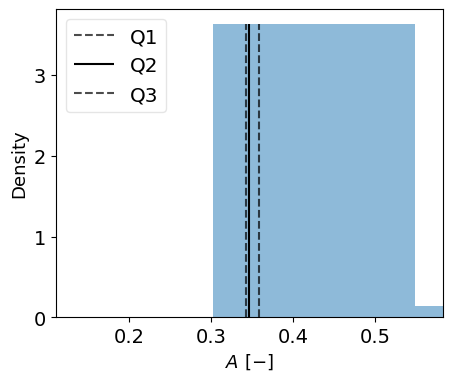

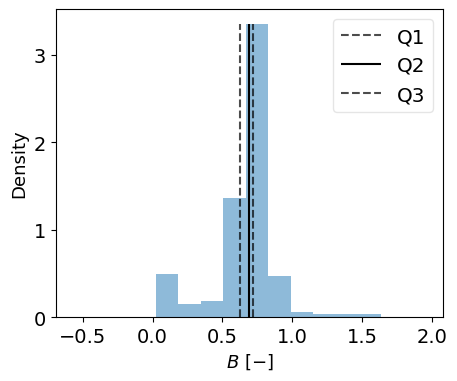

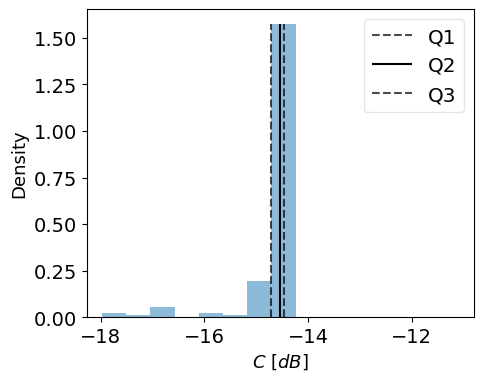

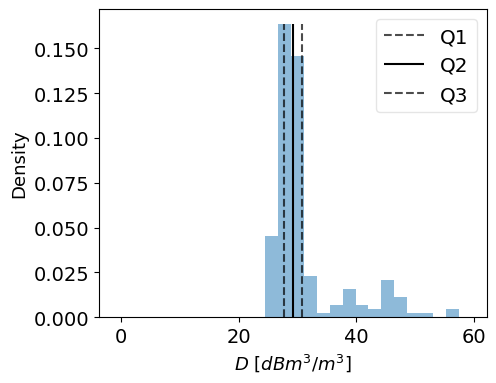

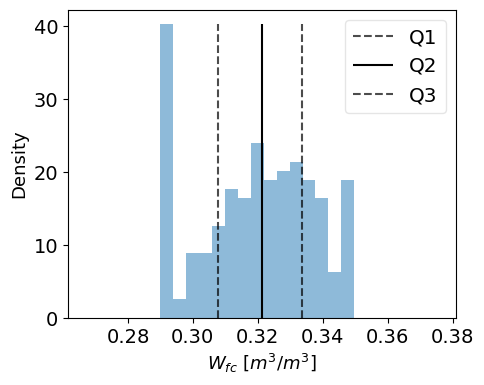

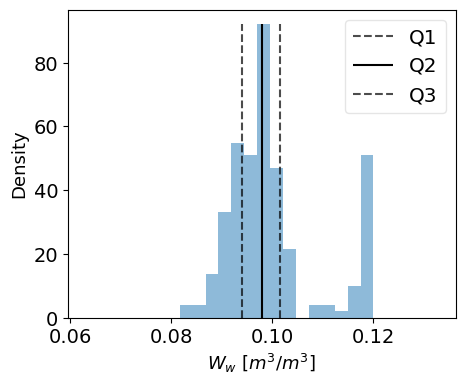

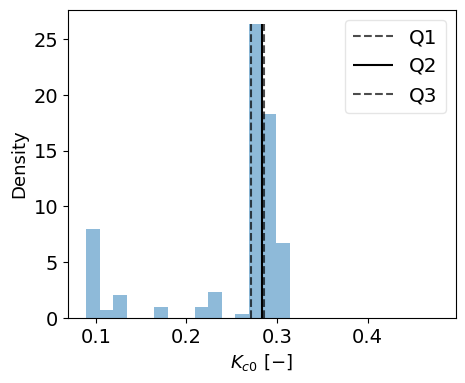

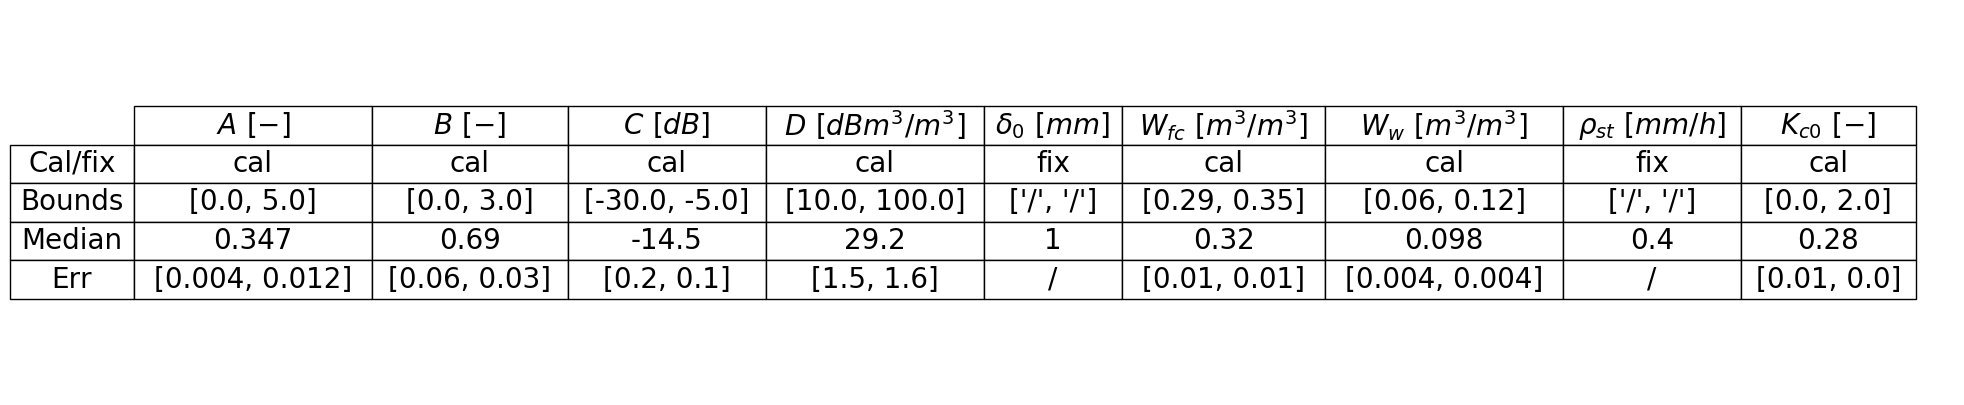

RMSE = 1.38646622383859
R= 0.6947276856625106
bias = -0.03200581562252242
KGE= 0.6946642735321336


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

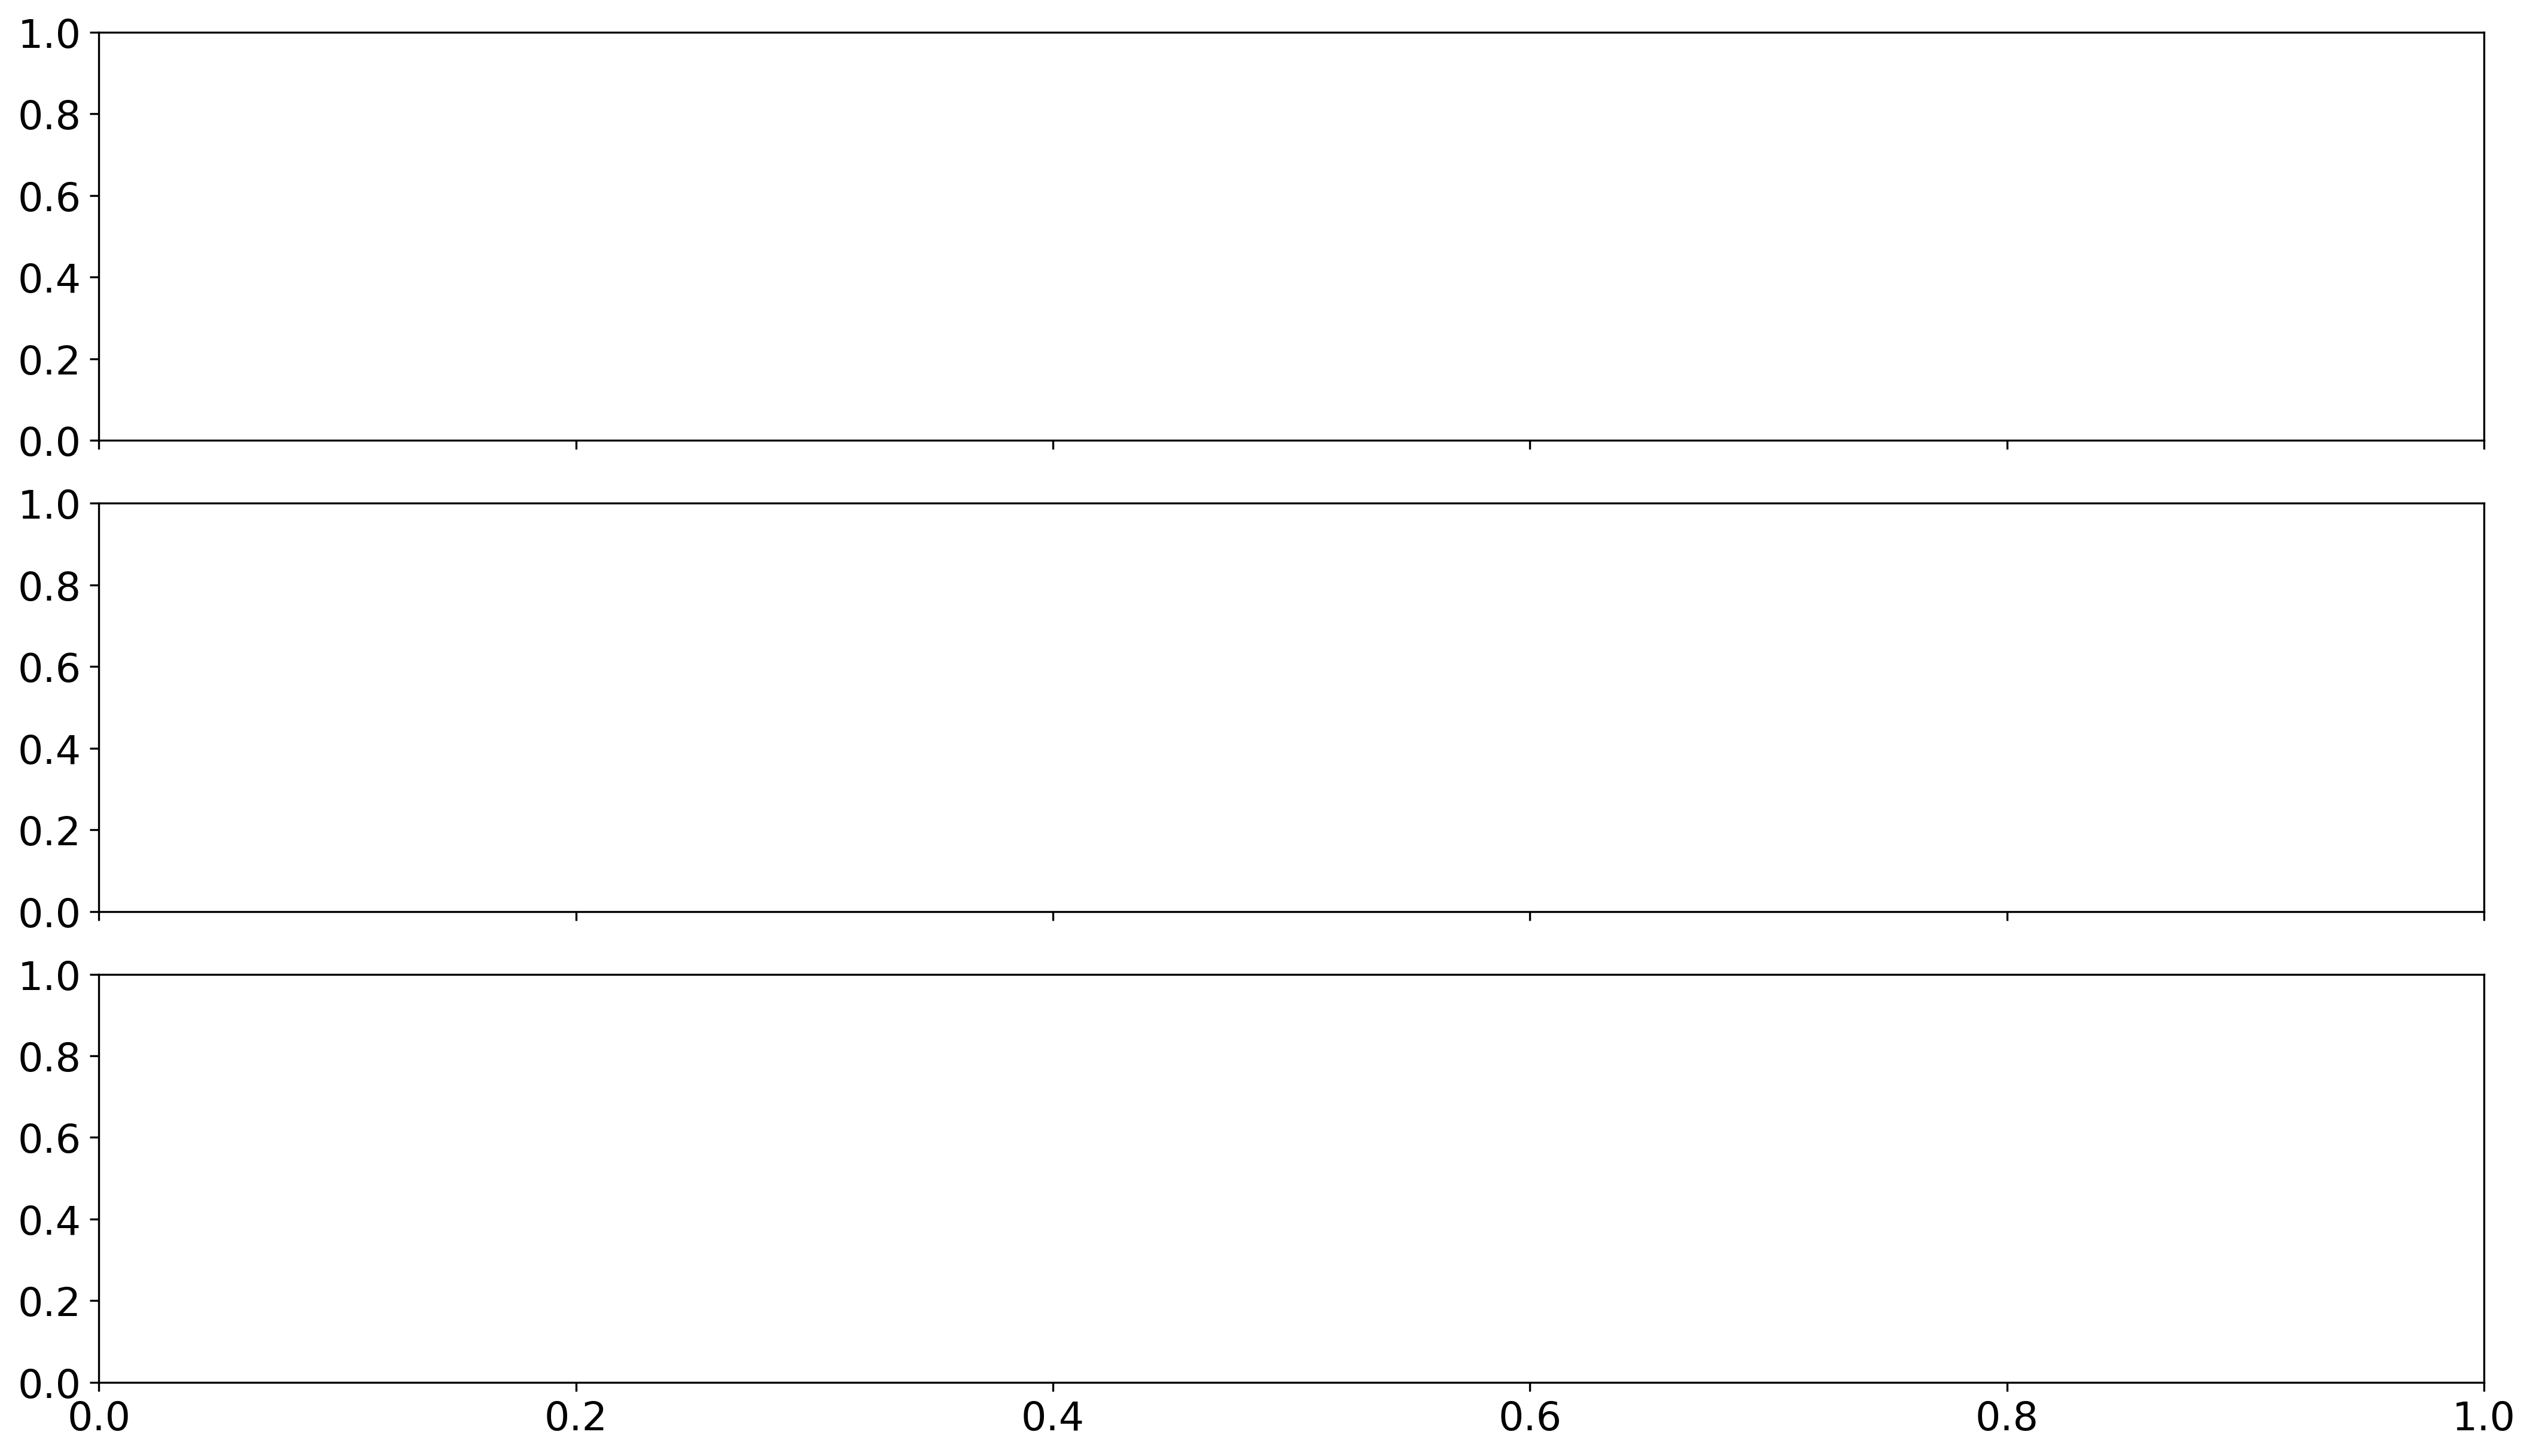

In [52]:
#############################################################################
# User choice
#############################################################################
opt_show = True if input('Show plots? [y/n]')=='y' else False
# automate = False

#############################################################################
# Analysis
#############################################################################

for y in [year]:
    for opt_fit_label in ['no-fit']:
        
        timestr=f'Simul_DEF\\{y}_PB\\{opt_fit_label}'
        PAR_dict = {label : PAR_DICTS[y][opt_fit_label][label] for label in PAR_DICTS[y][opt_fit_label]}
        
        opt_fit = True if opt_fit_label=='fit' else False
        _, rowLabels = parameters_analysis_fromfile(
            PAR_dict, PARn_str,
            timestr=timestr,
            automate=automate,
            opt_fit=opt_fit,
            nbins=15, opt_show=opt_show,)
        plt.close()
                
        if automate: opt_save=True
        else: opt_save = True if input('Save log with parameters\' values? [y/n]')=='y' else False
        
        if opt_save:
            for label in PAR_dict:
                if len(PAR_dict[label])>5: PAR_dict[label].pop(5)
            try:
                with open('Plot\\'+timestr+'_params.txt', 'w') as f:
                    f.write(f'PAR_DICTS_{y}_{opt_fit_label}='+'{'+'\n')
                    for key, value in PAR_dict.items():
                        f.write("r'%s':%s,\n" % (key, value))
                    f.write('}')
            except ValueError: pass
            
        #####################################################################
        # Simulations
        #####################################################################
        PARn = [PAR_dict[label][3] for label in PAR_dict if label in PARn_str]
        WW,IRR,sigma0,KGE = IRR_WCM(PARn, inputs, user_in)

        
        #####################################################################
        # Table with param
        #####################################################################
        if automate: opt_save_table = True
        else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False
        
        fig, ax = plt.subplots(figsize=(24,5))
        row_height=0.1; col_width=0.1
        
        single_label = [label for label in PAR_dict][0]
        cellText = [
            [PAR_dict[label][1],
            PAR_dict[label][2],
            significant_figures_str(PAR_dict[label][4][0],
                                    PAR_dict[label][3])[1] if label in PARn_str else PAR_dict[label][3],
            [float(significant_figures_str(PAR_dict[label][4][0],
                                           PAR_dict[label][4][0])[1]),
             float(significant_figures_str(PAR_dict[label][4][0],
                                           PAR_dict[label][4][1])[1])] if label in PARn_str else PAR_dict[label][4]]
            for label in PAR_dict]
        cellText = [ [cellText[i][j] for i in range(len(cellText))]
                    for j in range(4)]
        
        colLabels = [ f'{label} {PAR_dict[label][0]}' for label in PAR_dict ]
        
        table = ax.table(cellText=cellText,
                          cellLoc='center', loc='center',
                          colLabels=colLabels,
                          rowLabels=rowLabels,
                        )
        
        for (row, col), cell in table.get_celld().items():
            if row == 0: # or col == 0:
                cell.set_text_props(weight='bold')
            cell.set_height(row_height)
            cell._loc = 'center'
        
        table.auto_set_font_size(False); table.set_fontsize(20)
        table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
        ax.axis('tight'); ax.axis('off')
        
        if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.png')
        if opt_show: plt.show()
        plt.close()
        
        #####################################################################
        # Triple plot
        #####################################################################
        
        from scipy.signal import savgol_filter
                
        if automate: opt_save = True
        else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False
        
        fig, ax = plt.subplots(3, 1,constrained_layout=True,figsize=(14, 8), sharex=True,dpi=300,)
        filename = f'_triple_'+units+'_'+PAR_str_add
        from scipy.signal import savgol_filter
        
        plot_triple(fig, ax, times1=t_sat, data1=[VV, sigma0], data1_label=r'$\sigma^0$', 
                    input1=veg, input1_label=opt_veg,
                    times2=t,
                    data2=[WW_obs, WW],
                    data2_label=r'SM',
                    input2=[], input2_label='',
                    times3=t, data3=
                    [P,
                     IRR_obs,
                     savgol_filter(EPOT, window_length=25, polyorder=1, mode='constant')],
                    data3_label=['Rain', ' Irrigation', 'mean ET0'],
                    user_input=[irri],
                   )
        
        ax[0].set_ylim(-17, -3)
        if year==2020: ax[1].set_ylim(0.06, .5)
        ax[2].set_ylim(0, 25)

        for axi in ax:
            # axi.set_xlim(xmin=pd.Timestamp('2017-04-01'), xmax=pd.Timestamp('2017-11-05'))
            axi.tick_params(axis='both', labelsize=16)
            # plt.setp(axi.get_xticklabels(), rotation=45, ha="right",
            # rotation_mode="anchor")

        name=''
        if opt_save:
            optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
            name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
            print('Triple path: ', 'Plot\\', name)
            plt.savefig('Plot\\'+name+'.tiff', format='tiff')
        
        if opt_show: plt.show()
        plt.close()
        
        
        #####################################################################
        # Scatterplot
        #####################################################################
        
        if automate: opt_save = True
        else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False
        
        filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'
        
        plot_sim_vs_obs(sim=WW, obs=WW_obs, quantity='SM', um='[-]')
            
        if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')
        if opt_show: plt.show()
        plt.close()
        
        if automate: opt_save = True
        else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False
        
        filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'sigma0'
        
        plot_sim_vs_obs(sim=sigma0, obs=VV, quantity=r'$\sigma^0$', um='[dB]')
            
        if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.png')
        if opt_show: plt.show()
        plt.close()

In [61]:
time_start = pd.Timestamp('2017-04-04')
time_end = pd.Timestamp('2017-05-23')
VV_cut     = input_wcm.loc[time_start:time_end]['VV'].values
sigma0_cut = pd.DataFrame(sigma0, index=pd.DatetimeIndex(t_sat)).loc[time_start:time_end].values
WW_cut = pd.DataFrame(WW, index=pd.DatetimeIndex(t)).loc[time_start:time_end].values
WW_obs_interp_cut = pd.DataFrame(WW_obs_interp, index=pd.DatetimeIndex(t)).loc[time_start:time_end].values
print('season: FALL')
print('sigma0 KGE: ', he.evaluator(he.kge, sigma0_cut, VV_cut)[0])
print('W KGE: ', he.evaluator(he.kge, WW_cut, WW_obs_interp_cut)[0])

season: FALL
sigma0 KGE:  [0.81870572]
W KGE:  [0.59036876]


In [ ]:
raise NameError('stop')

# Simulations with different params

In [38]:
def IRR_WCM_reduced(PAR, inputs, user_in):
    # User input
    irri, units = user_in
    
    # Unpack inputs
    A, B, Kc0 = PAR
    t, t_sat, P, IRR_obs, EPOT, Kc, WW_obs, WW_sat, veg, angle, sig0_obs, freq, C, D, d_0, WW_fc, WW_w, rho_st  = inputs
    
    angle_m = np.mean(angle)
    Ks      = 0. # water stress coefficient
    rho     = 0. # depletion fraction
    WW      = np.array([.0]*len(t)) # water content [m3/m3]
    WW[0]   = WW_obs[0] # initial value of sm [m3/m3]
    depth   = 0. # dynamic depth [mm]
    sig0    = np.array([.0]*len(t_sat)) # backscattering
    
    COST   = .0   # additional cost to KGE
    LAMBDA = 1000 # Lagrange multiplier
    
    for i in [i+1 for i in range(len(t)-1)]:
        
        # Compute DoI of W[i-1]
        depth = doi(freq=freq,
                    sand=45, clay=15,
                    water=WW[i-1],
                    angle=angle_m)\
                    *1000\
                    # *W_max\
            # *1000 is to account for going from [m] to [mm]
        
        # Build Ks curve    
        # Compute crop coeff and depletion fraction
        rho=rho_st+0.04*(5-Kc[i]*Kc0*EPOT[i]*24)
        if   rho<0.1: COST += (rho-0.1)**2 # regularization
        elif rho>0.8: COST += (rho-0.8)**2 # regularization
        
        if WW[i-1]>=(1-rho)*WW_fc:
            Ks=1
        elif (WW[i-1]>WW_w)and(WW[i-1]<(1-rho)*WW_fc):
            Ks=float(float(WW[i-1]-WW_w)/float((1-rho)*(WW_fc-WW_w)))
        else: Ks=0
        
        # Water balance [mm]
        WW[i]=WW[i-1]+(P[i]+IRR_obs[i]-EPOT[i]*Kc[i]*Kc0*Ks)/(depth)
        
        # Computation of deep percolation (water above field capacity)
        if WW[i]>WW_fc: WW[i]=WW_fc
            
    WWsat = np.array([ x[1] for x in timeseries(t,WW) if x[0] in t_sat ])
    
    # Water Cloud Model
    sig0,KGE = WCM([A,B,C,D], [WWsat,veg,angle,sig0_obs], units=units)
    
    KGE += -LAMBDA*COST
    
    return [WW,IRR_obs,sig0,KGE]

In [39]:
PAR_DICTS_2017_no_fit={
r'$A$':['$[-]$', 'cal', [0.0, 5.0], 0.353, np.array([0.011, 0.049])],
r'$B$':['$[-]$', 'cal', [0.0, 3.0], 0.695, np.array([0.191, 0.076])],
r'$C$':['$[dB]$', 'cal', [-30.0, -5.0], -15.959, np.array([1.793, 0.861])],
r'$D$':['$[dB m^3/m^3]$', 'cal', [10.0, 100.0], 36.086, np.array([ 5.718, 10.561])],
r'$\delta_0$':['$[mm]$', 'cal', [1.0, 2.0], 1.004, np.array([0.003, 0.018])],
r'$W_{fc}$':['$[m^3/m^3]$', 'cal', [0.2, 0.4], 0.292, np.array([0.033, 0.041])],
r'$W_w$':['$[m^3/m^3]$', 'cal', [0.07, 0.17], 0.111, np.array([0.014, 0.019])],
r'$\rho_{st}$':['$[mm/h]$', 'cal', [0.1, 0.8], 0.208, np.array([0.061, 0.073])],
r'$K_{c0}$':['$[-]$', 'cal', [0.0, 2.0], 0.254, np.array([0.028, 0.015])],
}

In [ ]:
raise NameError('remember to provide PAR_dict!!')

In [40]:
#####################################################################
# Simulations
#####################################################################

if input('Plot with different params? [y/n]')=='y':
    opt_params_year = int(input('Year for params?'))
    opt_params_fit = input('From fit or no-fit?')
    
        #!!!!!!!!!!!!!!#
    PAR_dict = PAR_DICTS_2017_no_fit # PAR_DICTS[opt_params_year][opt_params_fit]
        #!!!!!!!!!!!!!!#
    
    timestr=f'Simul_DEF\\{year}_FB\\params-{opt_params_year}-{opt_params_fit}'
    # PAR_dict[r'$\rho_{st}$'][3] = 0.4 if year==2017 else 0.5
    opt_show = True if input('Show things like tables, plots, y\' kno!?')=='y' else 'n'
    
nrun = 1
n_particles = 20
n_step = 200
verbose_calib = True

In [41]:
if input('Set freq to 1.4 GHz? [y/n]')=='y':
    inputs[-2] = 1.4 # set frequency to 1.4 GHz

In [ ]:
raise NameError('If you are not calibrating, raw the following code')

/home/martina/Documents/thesis-codes/conda/envs/satellite_libraries_libraries/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


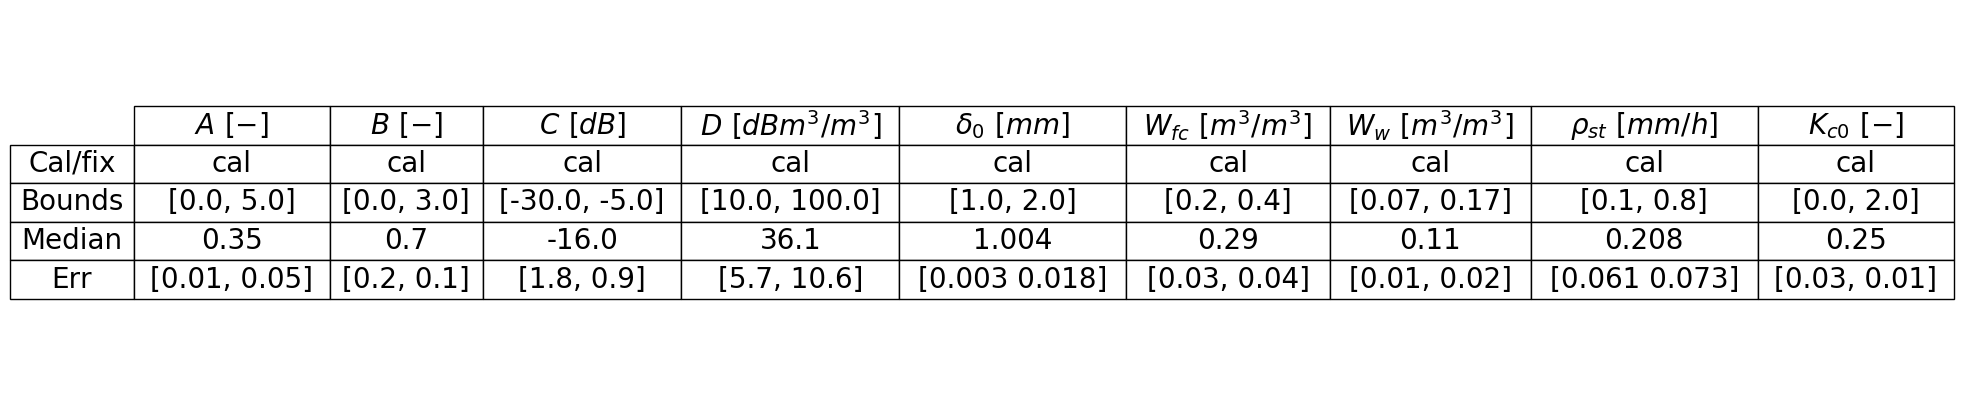

In [42]:
#####################################################################
# Table with param
#####################################################################

if automate: opt_save_table = True
else: opt_save_table = True if input('Save table with params? [y/n]')=='y' else False

fig, ax = plt.subplots(figsize=(24,5))
row_height=0.1; col_width=0.1

single_label = [label for label in PAR_dict][0]
cellText = [
    [PAR_dict[label][1],
    PAR_dict[label][2],
    significant_figures_str(PAR_dict[label][4][0],
                            PAR_dict[label][3])[1] if label in PARn_str else PAR_dict[label][3],
    [float(significant_figures_str(PAR_dict[label][4][0],
                                   PAR_dict[label][4][0])[1]),
     float(significant_figures_str(PAR_dict[label][4][0],
                                   PAR_dict[label][4][1])[1])] if label in PARn_str else PAR_dict[label][4]]
    for label in PAR_dict]
cellText = [ [cellText[i][j] for i in range(len(cellText))]
            for j in range(4)]

colLabels = [ f'{label} {PAR_dict[label][0]}' for label in PAR_dict ]
rowLabels = ['Cal/fix', 'Bounds', 'Median', 'Err']

table = ax.table(cellText=cellText,
                  cellLoc='center', loc='center',
                  colLabels=colLabels,
                  rowLabels=rowLabels,
                )

for (row, col), cell in table.get_celld().items():
    if row == 0: # or col == 0:
        cell.set_text_props(weight='bold')
    cell.set_height(row_height)
    cell._loc = 'center'

table.auto_set_font_size(False); table.set_fontsize(20)
table.auto_set_column_width(col=[x for x in range(len(PAR_dict))])
ax.axis('tight'); ax.axis('off')

if opt_save_table: plt.savefig(f'Plot\\{timestr}_table.svg')
if opt_show: plt.show()
plt.close()

In [45]:
model = int(input('Which model to use? [1 for IRR_WCM_allpar, 2 for IRR_WCM, 3 for IRR_WCM_reduced]'))
if model==1: model_func = IRR_WCM_allpar; inputs=inputs[:-1]
elif model==2: model_func = IRR_WCM
elif model==3: model_func = IRR_WCM_reduced

In [46]:
opt_show=True
PARn = [PAR_dict[label][3] for label in PAR_str]
WW,IRR,sigma0,KGE = model_func(PARn, inputs, user_in)

ValueError: too many values to unpack (expected 3)

ValueError: window_length must be odd.

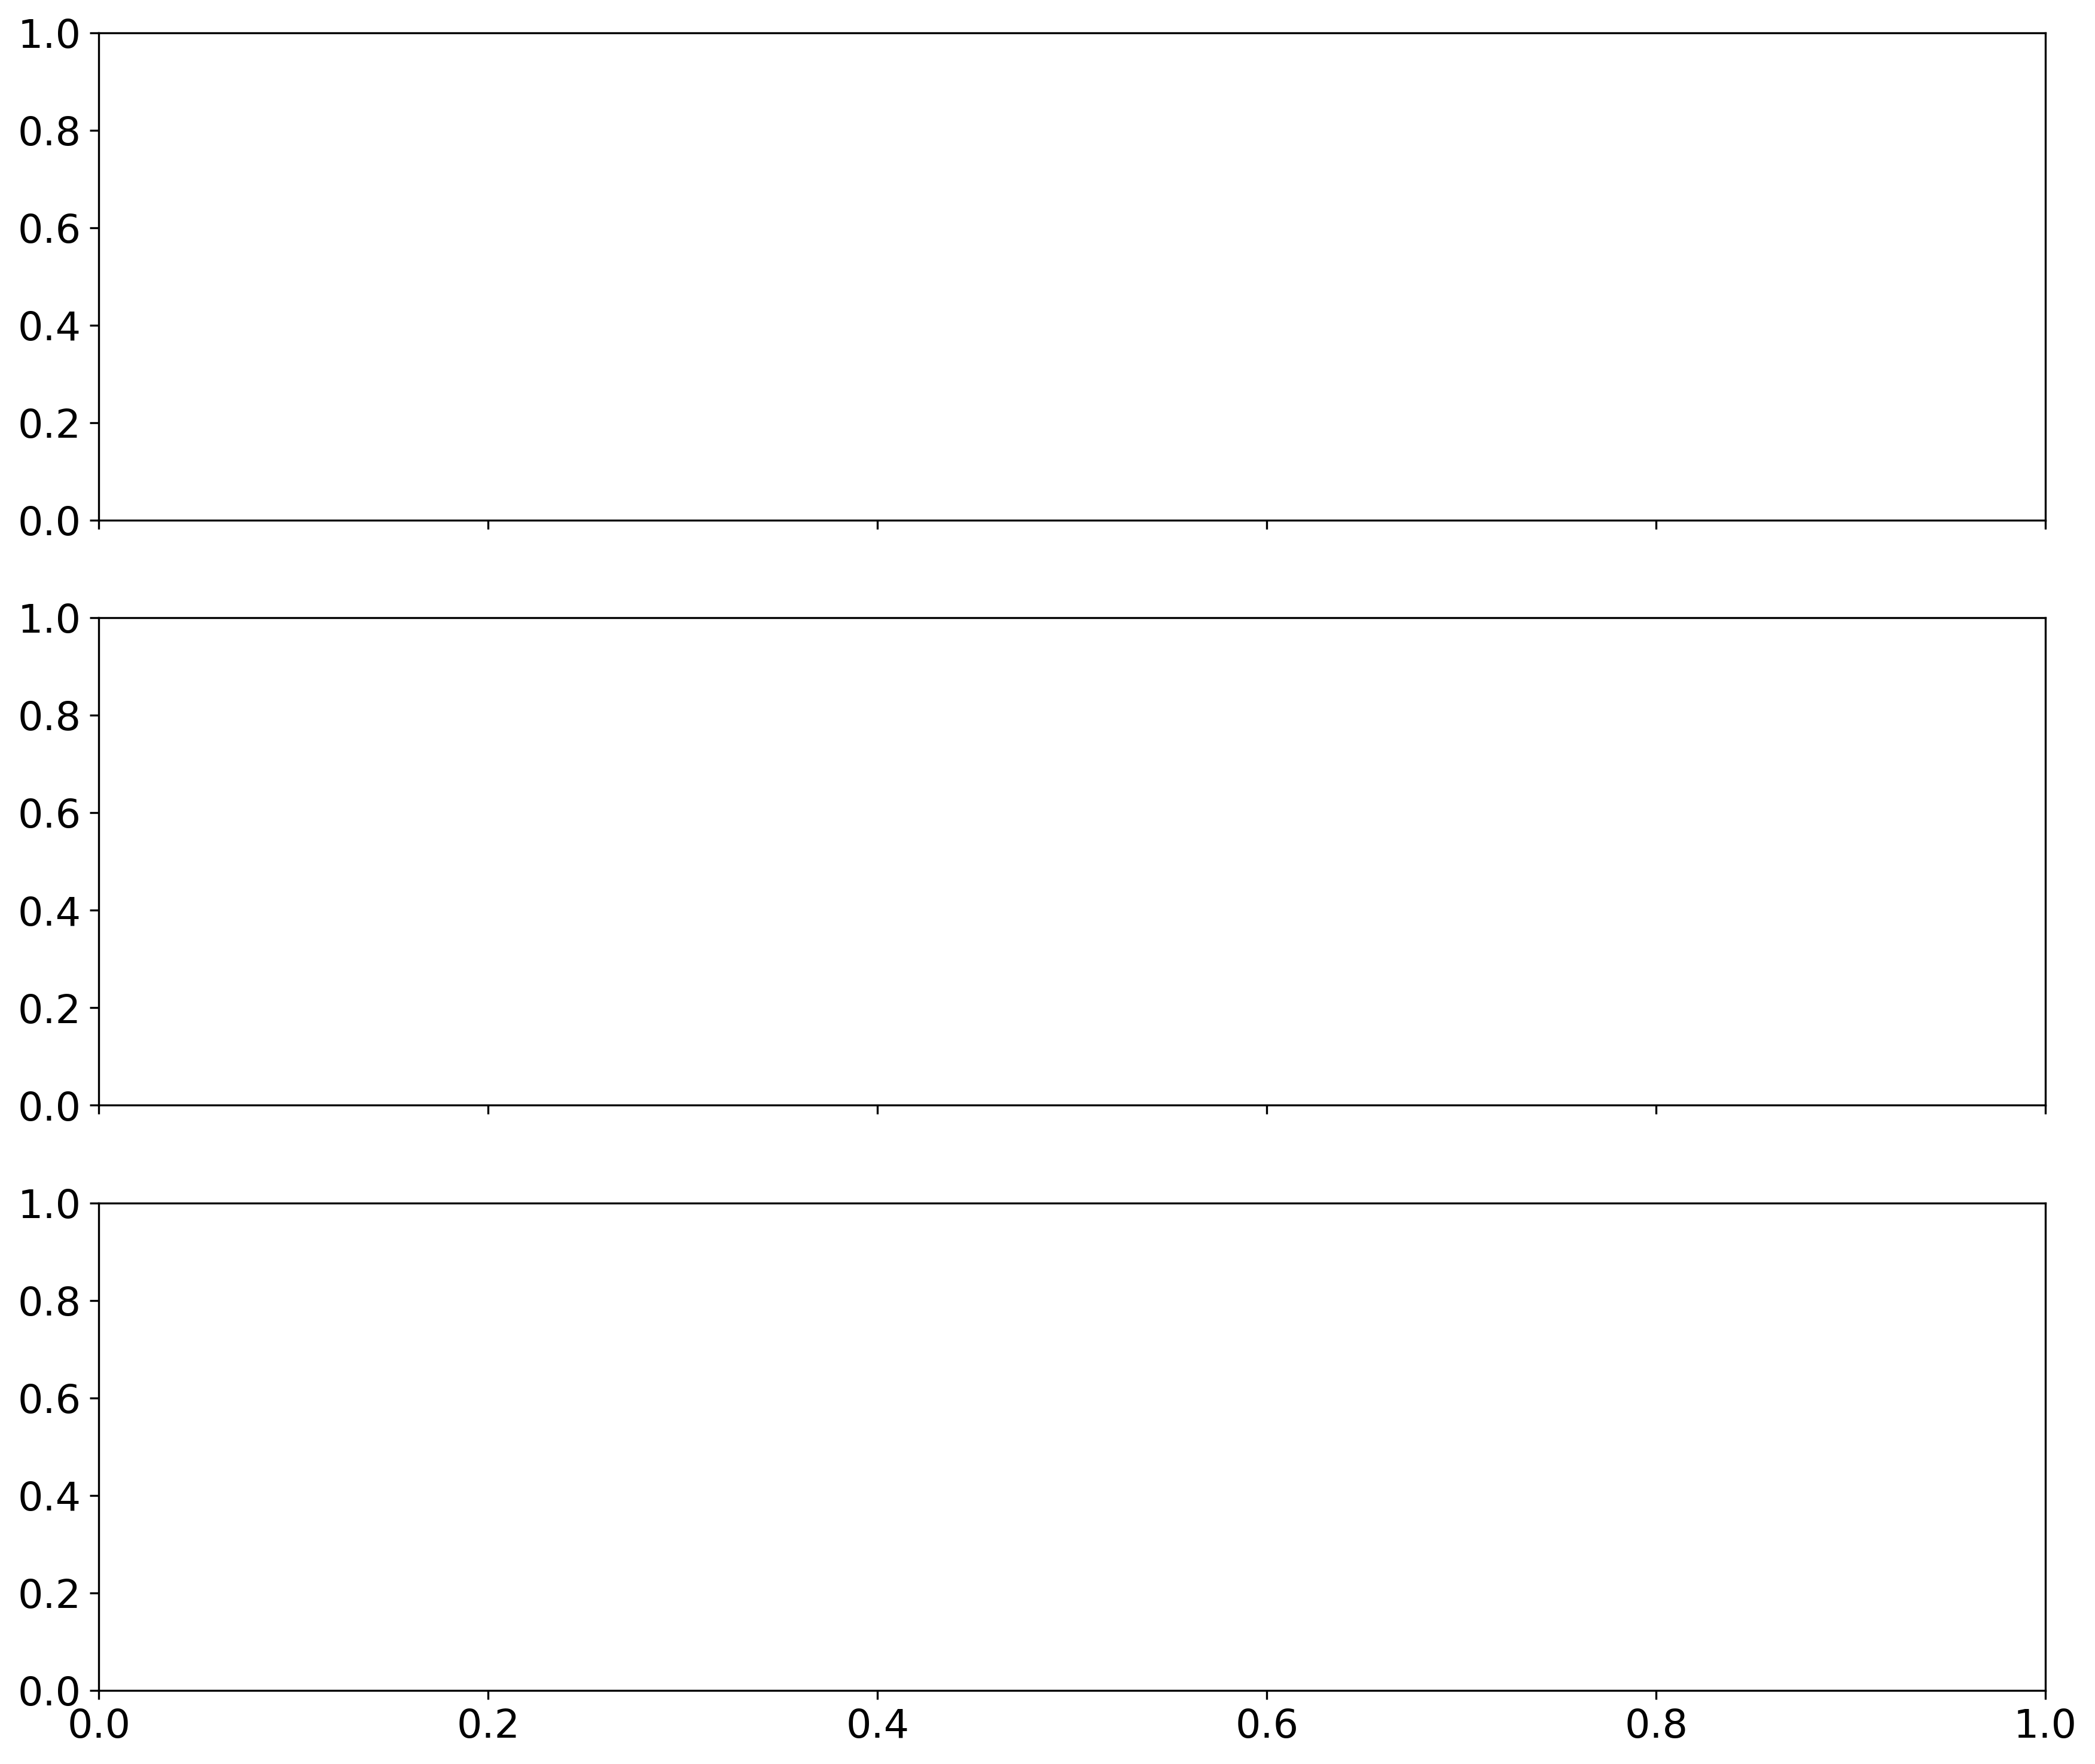

In [47]:
#####################################################################
# Triple plot
#####################################################################
        
from scipy.signal import savgol_filter
        
if automate: opt_save = True
else: opt_save = True if input('Save triple plot SM+s0+inputs? [y/n]')=='y' else False

fig, ax = plt.subplots(3, 1,constrained_layout=False,figsize=(14, 12), sharex=True,dpi=300,)
filename = f'_triple_'+units+'_'+PAR_str_add
from scipy.signal import savgol_filter

plot_triple(fig, ax, times1=t_sat, data1=[VV, sigma0], data1_label=r'$\sigma^0$', 
            input1=veg, input1_label=opt_veg,
            times2=t, data2=[WW_obs, WW], data2_label=r'SM',
            input2=[], input2_label='',
            times3=t, data3=
            [P,
             IRR_obs,
             savgol_filter(EPOT, window_length=25, polyorder=1, mode='interp')],
            data3_label=['Rain', ' Irrigation', 'mean ET0'],
            user_input=[irri],
           )

if year==2020:
    ax[1].set_ylim(0.06, .5)
    ax[2].set_ylim(0, 40)

name=''
if opt_save:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    name = timestr+filename # +f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    plt.savefig('Plot\\'+name+'.svg')

if opt_show: plt.show()
plt.close()

In [ ]:
#####################################################################
# Scatterplot
#####################################################################

if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sm_'+units+PAR_str_add # 'SM'

plot_sim_vs_obs(sim=WW, obs=WW_obs, quantity='SM', um='[-]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.svg')
if opt_show: plt.show()
plt.close()

if automate: opt_save = True
else: opt_save = True if input('Save scatterplot of SM? [y/n]')=='y' else False

filename = f'scatter_'+'sigma0_'+units+PAR_str_add # 'sigma0'

plot_sim_vs_obs(sim=sigma0, obs=VV, quantity=r'$\sigma^0$', um='[dB]')
    
if opt_save: plt.savefig('Plot\\'+timestr+'_'+filename+'.svg')
if opt_show: plt.show()
plt.close()

# Components

In [ ]:
PAR_tot = [0.329, 0.56, -15, 30, 10, 0.32, 0.1, 0.4, 0.3]

A, B, C, D, W_max, WW_fc, WW_w, Kc0 = [PAR_dict[label][3] for label in PAR_dict]
t, t_sat, P, IRR_obs, EPOT, Kc, WW_obs, WW_sat, veg, angle, sig0_obs, freq, rho_st = inputs

angle_m = np.mean(angle)
Ks      = np.array([.0]*len(t)) # water stress coefficient
ET      = np.array([.0]*len(t)) # evapotranspiration
rho     = np.array([.0]*len(t)) # depletion fraction
PS      = np.array([.0]*len(t)) # deep percolation
W       = np.array([.0]*len(t)) # water content [mm]
WW      = np.array([.0]*len(t)) # water content [m3/m3]
WW[0]   = WW_obs[0] # initial value of sm [m3/m3]
depth   = np.array([.0]*len(t)) # dynamic depth [mm]
depth[0]= doi(freq=4, sand=45, clay=15, water=WW[0], angle=angle_m)*1000

W[0]    = WW_obs[0]*depth[0] # initial value of sm [mm]
sig0    = np.array([.0]*len(t_sat))

COST   = .0
LAMBDA = 1000
if irri==True: IRR = [0]*len(d) # daily, water content
else: IRR = IRR_obs


for i in [i+1 for i in range(len(t)-1)]:
    
    # Compute DoI of W[i-1]
    depth[i] = doi(freq=freq,
                sand=45, clay=15,
                water=WW[i-1],
                angle=angle_m)*1000
    
    # Build Ks curve    
    # Compute crop coeff and depletion fraction
    Kci = Kc[i]*Kc0
    rho[i]=rho_st+0.04*(5-Kci*EPOT[i]*24)
    if   rho[i]<0.1: COST += (rho[i]-0.1)**2 # regularization
    elif rho[i]>0.8: COST += (rho[i]-0.8)**2 # regularization
    
    if WW[i-1]>=(1-rho[i])*WW_fc:
        Ks[i]=1
    elif (WW[i-1]>WW_w)and(WW[i-1]<(1-rho[i])*WW_fc):
        Ks[i]=float(float(WW[i-1]-WW_w)/float((1-rho[i])*(WW_fc-WW_w)))
    else: Ks[i]=0
    
    # Water balance [mm]
    # W[i]=WW[i-1]*depth[i-1]+P[i]+IRR[i]-EPOT[i]*Kci*Ks[i]
    WW[i]=WW[i-1]+(P[i]+IRR[i]-EPOT[i]*Kci*Ks[i])/(depth[i])
    
    # Computation of deep percolation (water above field capacity)
    WW_s = 0.48
    if WW[i]>WW_s:
        WW[i]=WW_s
    elif WW[i]>WW_fc:
        WW[i]-=(WW[i]-WW_fc)*np.sqrt(60)

In [ ]:
theta  = angle*np.pi/180. # angle of incidence (rad)

sig0s_dB = C+D*WW_sat # sigma0_soil [dB]
T2 = np.exp((-2*B*veg)/np.cos(theta)) # attenuation
sig0v = A*veg*np.cos(theta)*(1-T2) # sigma0_veg [units]

if units=='lin':
    sig0s = db_lin(sig0s_dB) # sigma0_soil [lin]
    sig0_lin = T2*sig0s+sig0v # sigma0_tot [lin]
    sig0=lin_db(sig0_lin) # sigma0_tot [dB]
elif units=='db':
    sig0 = T2*sig0s_dB+sig0v # sigma0_tot [db]
else: raise NameError('Please choose one of the options: lin/db')

In [ ]:
plt.plot(Kc*Kc0)
plt.plot(Ks)

In [ ]:
Ks

In [ ]:
plt.plot(EPOT*Kc*Kc0*Ks)

In [ ]:
plt.plot((1-0.01+0.04*(5-EPOT*Kc*24*Kc0))*WW_fc)
plt.plot(np.array([1]*len(t))*WW_w)
# plt.ylim(0,0.2)

In [ ]:
plt.plot(WW)
plt.plot(WW_obs)

In [ ]:
plt.scatter(WW,WW_obs)

In [ ]:
plt.plot(depth)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(doi(freq=6, sand=45, clay=15, water=WW_obs, angle=angle_m)*1000)
ax0 = ax.twinx()
ax0.plot(WW_obs, color='tab:orange')

# Extrapolate depth curves

In [ ]:
from scipy.optimize import curve_fit

def doi(freq:float, sand:float, clay:float, water:np.array, angle:float):
    """
    freq [GHz]
    angle [°]
    
    return depth [m]
    """
    c = 299792458 # m/s
    theta  = angle*np.pi/180. # angle [rad]
    
    coeff = {
        1.4:
        {
        'real' : [2.862, -0.012, 0.001, 3.803, 0.462,
                  -0.341, 119.006, -0.500, 0.633],
        'img' : [0.356, -0.003, -0.008, 5.507, 0.044,
                 -0.002, 17.753, -0.313, 0.206]
        },
        4:
        {
        'real':[ 2.927,-0.012,-0.001,5.505,0.371,
                0.062,114.826,-0.389,-0.547],
        'img':[0.004,0.001,0.002,0.951,0.005,
               -0.01,16.759,0.192,0.29]
        },
        6:
        {
        'real':[1.993,0.002,0.015,38.086,-0.176,
                -0.633,10.72,1.256,1.522],
        'img':[-0.123,0.002,0.003,7.502,-0.058,
               -0.116,2.942,0.452,0.543]
        }
    }
    
    coeff_r = np.array(coeff[freq]['real'])
    real = coeff_r[0]+coeff_r[1]*sand+coeff_r[2]*clay+\
    (coeff_r[3]+coeff_r[4]*sand+coeff_r[5]*clay)*water+\
    (coeff_r[6]+coeff_r[7]*sand+coeff_r[8]*clay)*(water**2)
        
    coeff_i = np.array(coeff[freq]['img'])
    img = coeff_i[0]+coeff_i[1]*sand+coeff_i[2]*clay+\
    (coeff_i[3]+coeff_i[4]*sand+coeff_i[5]*clay)*water+\
    (coeff_i[6]+coeff_i[7]*sand+coeff_i[8]*clay)*(water**2)
    
    depth =  c/(2*np.pi*freq*1e9)*(np.sqrt(real)/img)*np.cos(theta)
    
    return depth


# Define the function to fit to the data
def fit_func(freq, a, b, c):
    return a*freq**2 + b*freq + c

# Define the frequencies and depths for each set of data points
sand = 45
clay = 15
angle = 40
freqs = [1.4, 4, 6]
depths = []
for freq in freqs:
    depths.append([doi(freq, sand, clay, water, angle) for water in np.arange(0, 0.51, 0.01)])

# Fit a curve to each set of data points
fits = []
for i in range(len(freqs)):
    popt, _ = curve_fit(fit_func, freqs[i], depths[i])
    fits.append(popt)

# Define the frequencies at which to estimate the depth
new_freqs = np.arange(0.1, 10.1, 0.1)

# Estimate the depth at the new frequencies using the fitted curves
new_depths = []
for i in range(len(new_freqs)):
    depth = fit_func(new_freqs[i], *fits[0])
    if new_freqs[i] > freqs[0]:
        depth = fit_func(new_freqs[i], *fits[1])
    if new_freqs[i] > freqs[1]:
        depth = fit_func(new_freqs[i], *fits[2])
    new_depths.append(depth)

In [ ]:
plt.plot(new_depths)